<a href="https://colab.research.google.com/github/biagio-incardona/biagio-incardona.github.io/blob/master/Report_Incardona_Biagio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Health Insurance Cross Sell Prediction Report</center>

![intro](https://gitlab.com/gerasia/temp/-/raw/master/new_intro.jpg)
<div style="text-align: right">  <b>MADE BY</b>: Incardona Biagio</div>
<div style="text-align: right">  <b>UNIVERSITY ID (MATRICOLA)</b>: 1000023753 </div>

## Context

Object to study of this report is the ***Health Insurance Cross Sell Prediction*** dataset, freely available on [Kaggle](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv).

The dataset consists in a single *csv* file containing informations about some potential customers of an Healt Insurance company. 
The Insurance company has provided Health Insurance to its customers now they need to identify if there are some   policyholders (customers) that will also be interested in Vehicle Insurance provided by the company.

## Content

The dataset has approximately 400.000 rows and 12 columns. These columns contains personal informations about the potential customer like age, gender, region code, but also informations about his car (if the user has one) and his life as a driver (if the user can drive). Since the dataset is labeled it contains also a *Response* variable, which tell us if the user has accepted the new contract or not. Sice we won't do a classification algorithm, we can delete this column or use it just for validating the clusters we will find (if any).

## Disclaimer

Since our machine is really powerless, using the entire dataset for some operations will takes even more than 4 hours of computing (real test, not finished the computation) or even a crash of the system, we will apply a random sampling of the dataset in order to reduce the number of rows from about 400.000 to 5.000 units and we will do all the analysis and discussions on the reduced dataset.

I know that in this way we are losing a lot of important informations and there are a lot of probabilities that the row reduction operation will be an high negative bias on the analysis, but this was the only way to compute some operations in a reasonable time! For example it's impossible to compute a $400.000 \times 400.000$ distance matrix 

## Packages

The following code cell will be used to import all the packages needed to this report

In [1]:
install.packages(c("devtools","Hmisc", "data.table", "NbClust","corrplot","spgs", "factoextra", "ggridges", "tidyr", "clustertend", "vcd", "ltm","StatMatch"))
library(ggplot2, warn.conflicts = F, quietly = T)
library(dplyr, warn.conflicts = F, quietly = T)
library(Hmisc, warn.conflicts = F, quietly = T)
library(data.table, warn.conflicts = F, quietly = T)
library(corrplot, warn.conflicts = F, quietly = T)
library(factoextra, warn.conflicts = F, quietly = T)
library(ggridges, warn.conflicts = F, quietly = T)
library(tidyr, warn.conflicts = F, quietly = T)
library(clustertend, warn.conflicts = F, quietly = T)
library(vcd, warn.conflicts = F, quietly = T)
library(ltm, warn.conflicts = F, quietly = T)
library(StatMatch,warn.conflicts = F, quietly = T)
library(cluster)
library(devtools)
install_github("biagio-incardona/myClValid")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘png’, ‘jpeg’, ‘checkmate’, ‘car’, ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘zoo’, ‘mvtnorm’, ‘expm’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’, ‘plyr’, ‘lmtest’, ‘msm’, ‘polycor’, ‘proxy’, ‘survey’, ‘lpSolve’


corrplot 0.84 loaded

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

 

mltools (NA -> 0.3.5) [CRAN]


Installing 1 packages: mltools

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpIjAblO/remotes3964a72127/biagio-incardona-myClValid-dc8dd22/DESCRIPTION’
─  preparing ‘myClValid’:
✔  checking DESCRIPTION meta-information
✔  checking vignette meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘myClValid_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## 1. Preliminar analysis and data cleaning

Let's start importing the file into the system.

In [2]:
# Loading the dataset into the 'insurance.data' variable
insurance.data <- read.csv('Healt_Insurance.csv')

First of all we will get a random sampled version of the dataset

In [3]:
set.seed(12999)

rows <- sample(1:nrow(insurance.data), 5000)

insurance.data <- insurance.data[rows,]

Let's show the table.

In [4]:
head(insurance.data)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
,<int>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>
37637,37637,Male,62,1,29,1,1-2 Year,No,45016,26,244,0
4927,4927,Female,39,1,14,1,1-2 Year,No,40861,26,31,0
27798,27798,Male,33,1,28,0,< 1 Year,Yes,39897,124,126,1
19881,19881,Male,41,1,28,0,1-2 Year,Yes,42419,26,112,1
37334,37334,Male,48,1,28,0,> 2 Years,Yes,42038,155,65,0
15952,15952,Male,25,1,23,1,< 1 Year,No,25158,152,39,0


Now let's see if there are missing values

In [5]:
# for each value check if is missing or not
df.na <- is.na(insurance.data)

# for each column check how many missing values are there
apply(df.na, 2, sum)

id               Gender                  Age 
                   0                    0                    0 
     Driving_License          Region_Code   Previously_Insured 
                   0                    0                    0 
         Vehicle_Age       Vehicle_Damage       Annual_Premium 
                   0                    0                    0 
Policy_Sales_Channel              Vintage             Response 
                   0                    0                    0

Fortunately the dataset has not any missing values, so we can go on with our analysis without any fear.

Initially we will analyze and discuss the dataset structure.

In [6]:
str(insurance.data)

'data.frame':	5000 obs. of  12 variables:
 $ id                  : int  37637 4927 27798 19881 37334 15952 11893 7992 35286 35178 ...
 $ Gender              : chr  "Male" "Female" "Male" "Male" ...
 $ Age                 : int  62 39 33 41 48 25 46 35 35 52 ...
 $ Driving_License     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Region_Code         : num  29 14 28 28 28 23 28 28 47 28 ...
 $ Previously_Insured  : int  1 1 0 0 0 1 1 0 1 0 ...
 $ Vehicle_Age         : chr  "1-2 Year" "1-2 Year" "< 1 Year" "1-2 Year" ...
 $ Vehicle_Damage      : chr  "No" "No" "Yes" "Yes" ...
 $ Annual_Premium      : num  45016 40861 39897 42419 42038 ...
 $ Policy_Sales_Channel: num  26 26 124 26 155 152 124 26 152 25 ...
 $ Vintage             : int  244 31 126 112 65 39 289 295 125 258 ...
 $ Response            : int  0 0 1 1 0 0 0 1 0 0 ...


This dataset contains $n = 5000$ observations and $d = 12$ columns. Let's understand something about the variables:

### 1.1 ID

In [7]:
str(insurance.data$id)

 int [1:5000] 37637 4927 27798 19881 37334 15952 11893 7992 35286 35178 ...


It contains the identification number of each row and seems to be a 'row number count' variable with no particular informations.

In [8]:
# loading the rownames as integer into the 'indexs' variable
indexs <- as.integer(rownames(insurance.data))

# loading the id column into the 'ids' variable
ids <- insurance.data$id

# checking if the two vectors are equal
min(indexs == ids) == TRUE

[1] TRUE

Since the 'id' column is exactly a 'row number count' variable whe can delete it without losing informations 

In [9]:
insurance.data$id <- NULL

according to the reducted dimension of the dataset we will set the rownames as the vector  $[1,...,nrow(dataset)]$

In [10]:
rownames(insurance.data) <- 1:nrow(insurance.data)

### 1.2. Gender

In [11]:
str(insurance.data$Gender)

 chr [1:5000] "Male" "Female" "Male" "Male" "Male" "Male" "Female" "Male" ...


This is a categorical variable, containing informations about the gender of a potential customer.

We will transform it in a factor variable with 2 levels: "Female" and "Male".

In [12]:
insurance.data$Gender <- as.factor(insurance.data$Gender)

In [13]:
print(head(insurance.data$Gender))

[1] Male   Female Male   Male   Male   Male  
Levels: Female Male


Let's see how the two genders are distributed into the dataset

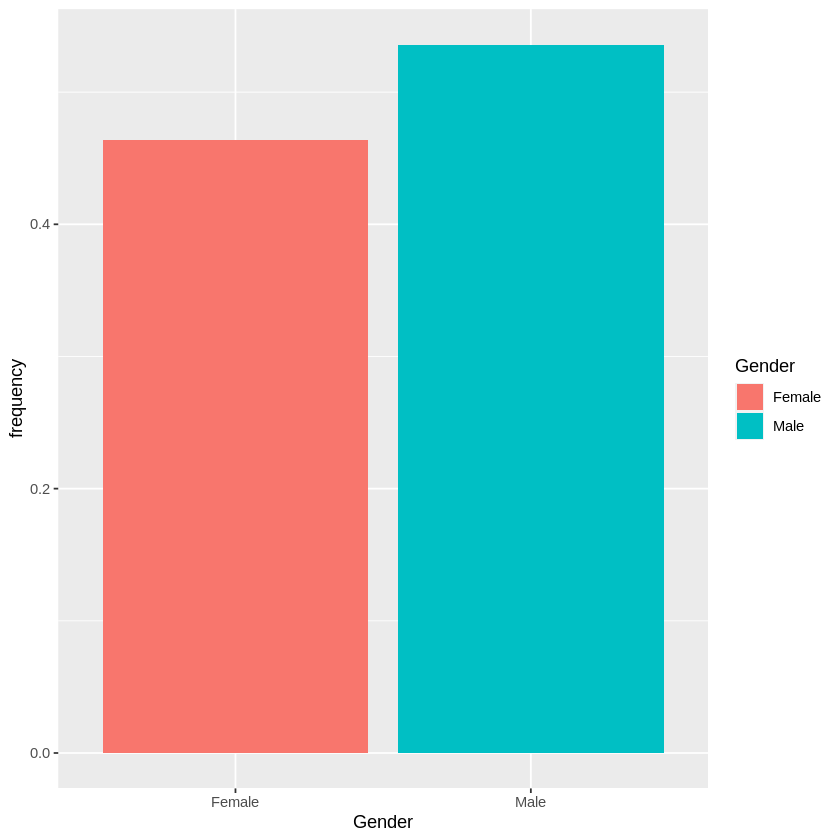

In [14]:
insurance.data %>%
    ggplot(aes(x = Gender, fill = Gender)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab('frequency')

As we can see thanks to the bar plot the two genders are pretty equally distributed into the dataset, since the **Females** are approximately the $45\%$ of the data and the **Males** are approximately the $55\%$ of the data.

### 1.3. Age

In [15]:
str(insurance.data$Age)

 int [1:5000] 62 39 33 41 48 25 46 35 35 52 ...


This is an integer variable containing the potential customer's age.
This could be an important information since the higher the age is the more the risks are and the insurance premium could become higher, but the thing is also true in reverse, as younger people are less experienced and generally more reckless.

Let's see how this important variable is distributed

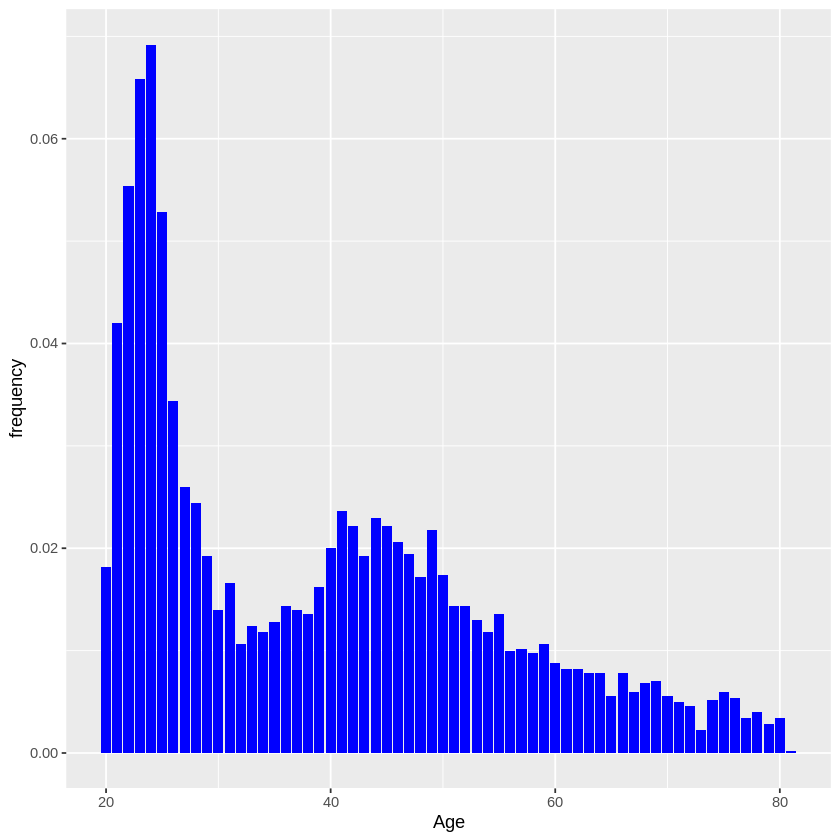

In [16]:
insurance.data %>%
    ggplot(aes(x = Age)) +
    geom_bar(aes(y = (..count..)/sum(..count..)), fill = "blue") +
    ylab("frequency")

It's interesting to see that the main part of the potential customers is between $20$ and $30$ years-old, it could mean that they are looking for their first insurance contract, so, since they are freshman they could be convinced easilier to sign with the company.

We can also see another peak in the plot, at the age interval $40-50$. This may be due to people having earned a fair amount of money and being looking for a better insurance contract.

### 1.4. Driving_License

In [17]:
str(insurance.data$Driving_License)

 int [1:5000] 1 1 1 1 1 1 1 1 1 1 ...


This is an integer variable and it may be ambiguous since it could count how many driving licenses one person have (car, truck, motorbike, ...) or it could just be a boolean value indicating if one person has a driving lincense or not.

First of all we will see how the data are distributed

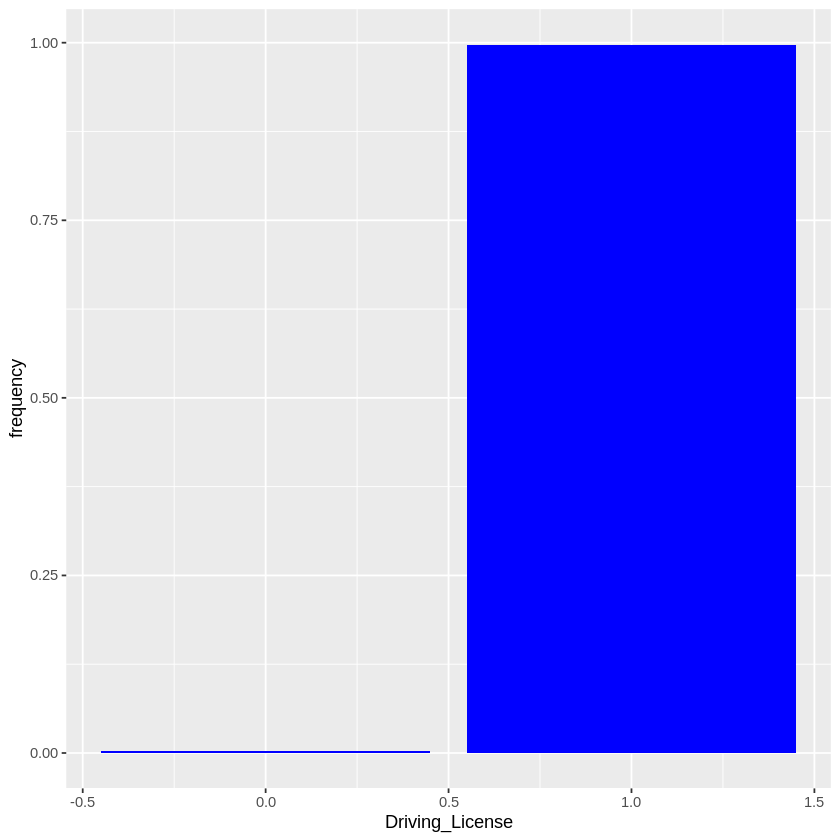

In [18]:
insurance.data %>%
    ggplot(aes(x = Driving_License)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),, fill = "blue") +
    ylab("frequency")

As we can see the variable act like a boolean one. This variable seems to be pretty useless since approximately the $100\%$ of the people has a driving license.

But, the absence of the driving license may significantly change the premium amount and be a crucial factor in the response of the non-driving people.

In order to make the dataset consistent we will transform this variable in a categorical one

In [19]:
insurance.data$Driving_License <- as.factor(if_else(insurance.data$Driving_License == 1, "Yes", "No"))

### 1.5. Region_Code

In [20]:
str(insurance.data$Region_Code)

 num [1:5000] 29 14 28 28 28 23 28 28 47 28 ...


This integer variable contains an unique code for the region of the customer. Let's see the distribution

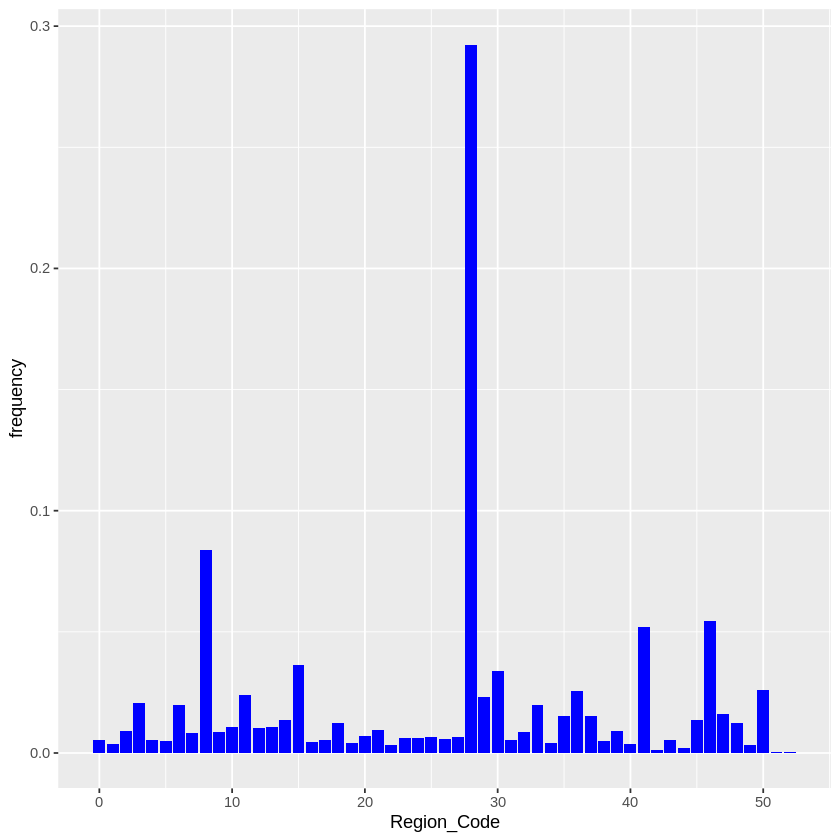

In [21]:
insurance.data %>%
    ggplot(aes(x = Region_Code)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),fill = "blue") +
    ylab("frequency")

from this graph we can see that most of the customers come from $7$ of the $52$ regions.

### 1.6. Previously_Insured

In [22]:
str(insurance.data$Previously_Insured)

 int [1:5000] 1 1 0 0 0 1 1 0 1 0 ...


This is another integer logical like variable that contains information about any previous vehicle insurance. 

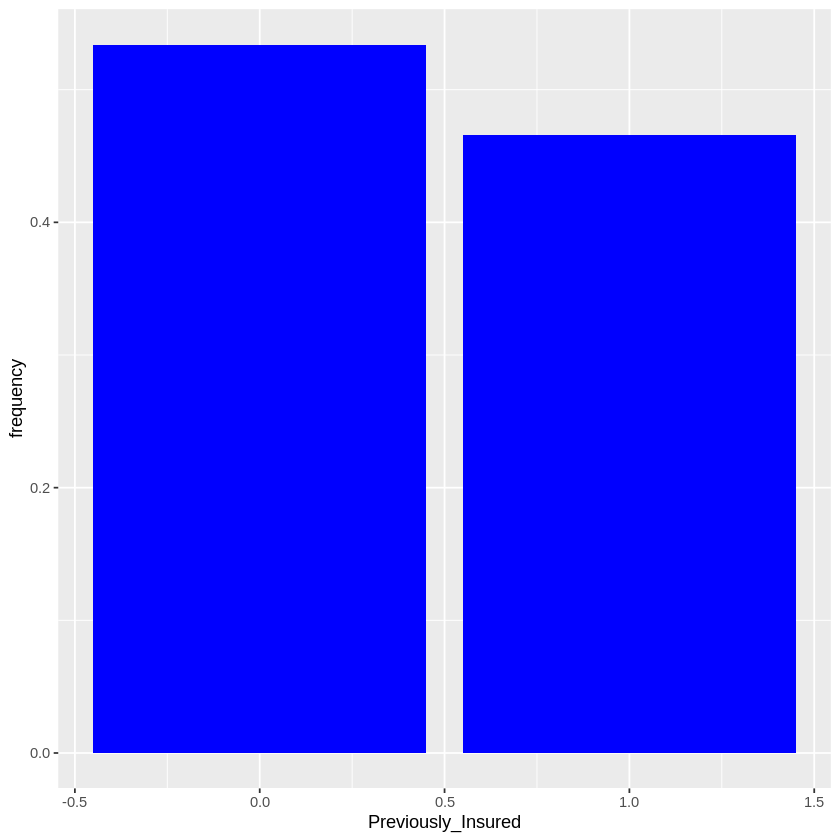

In [23]:
insurance.data %>%
    ggplot(aes(x = Previously_Insured, fill = Previously_Insured)) +
    geom_bar(aes(y = (..count..)/sum(..count..)), fill = "blue") +
    ylab("frequency")

Also this variable seems to be pretty equally distributed with a small overcoming of people with have no any insurance yet, has to be noted that this could be related to the fact that the most part of the dataset is composed by young people with their (probably) first car!

Let's make this variable categorical

In [24]:
insurance.data$Previously_Insured <- as.factor(if_else(insurance.data$Previously_Insured == 1, "Yes", "No"))

### 1.7. Vehicle_Age

In [25]:
str(insurance.data$Vehicle_Age)

 chr [1:5000] "1-2 Year" "1-2 Year" "< 1 Year" "1-2 Year" "> 2 Years" ...


This variable is a 3 levels factor, since the car's age is an important factor due to the amount of the annual premium, it could make sense to think that the older it is the higher the prize will be, we need to make sure these factors are ordered

In [26]:
is.ordered(insurance.data$Vehicle_Age)

[1] FALSE

The variable is not ordered, so we have to do this by our own

In [27]:
levels(insurance.data$Vehicle_Age)

NULL

In [28]:
# ordering the factors
insurance.data$Vehicle_Age <- ordered(insurance.data$Vehicle_Age, levels = c('< 1 Year','1-2 Year', '> 2 Years'))

# check if the variable becomes ordered
is.ordered(insurance.data$Vehicle_Age)

[1] TRUE

In [29]:
# check that the order is correct
print(head(insurance.data$Vehicle_Age))

[1] 1-2 Year  1-2 Year  < 1 Year  1-2 Year  > 2 Years < 1 Year 
Levels: < 1 Year < 1-2 Year < > 2 Years


Now we can see how the factors are distributed

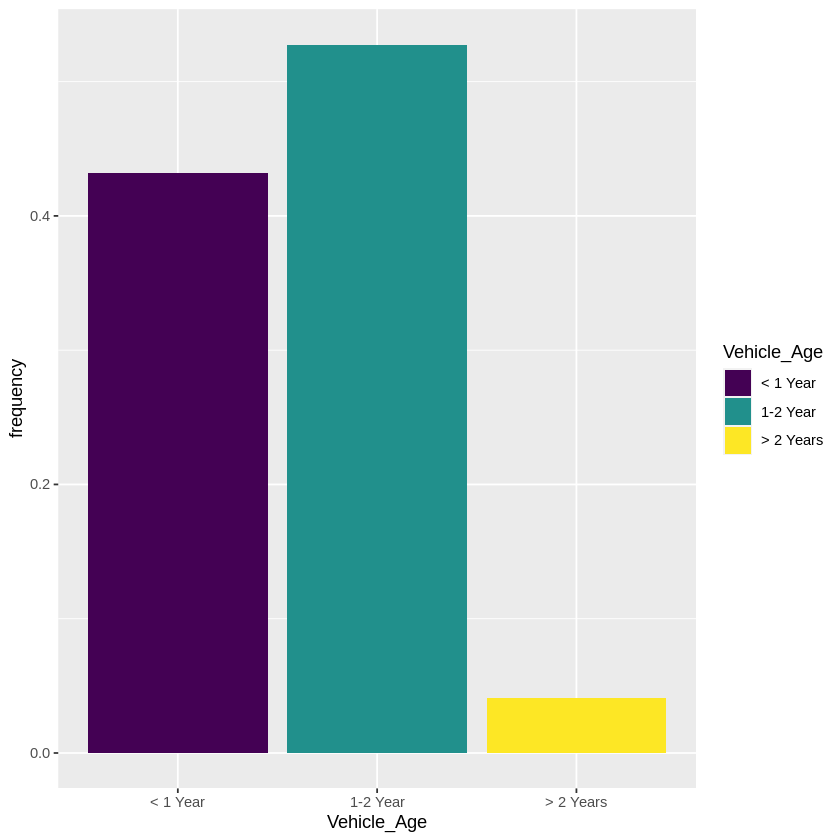

In [30]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Age, fill = Vehicle_Age)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab("frequency")

The majority of the cars are pretty new, so may have sense to think that this variable has not a lot of utility.

Since it is an ordered categorical variable we preffer to transform it in a numeric variable

In [31]:
insurance.data$Vehicle_Age <- as.integer(insurance.data$Vehicle_Age)

### 1.8. Vehicle_Damage	

In [32]:
str(insurance.data$Vehicle_Damage)

 chr [1:5000] "No" "No" "Yes" "Yes" "Yes" "No" "No" "Yes" "No" "Yes" "Yes" ...


This is a char variable acting like a 2-level factorial variable, containing information on whether or not the customer got his/her vehicle damaged. 

We are going to transform it in a factor variable.

In [33]:
insurance.data$Vehicle_Damage <- as.factor(insurance.data$Vehicle_Damage)


Let's see the distribution

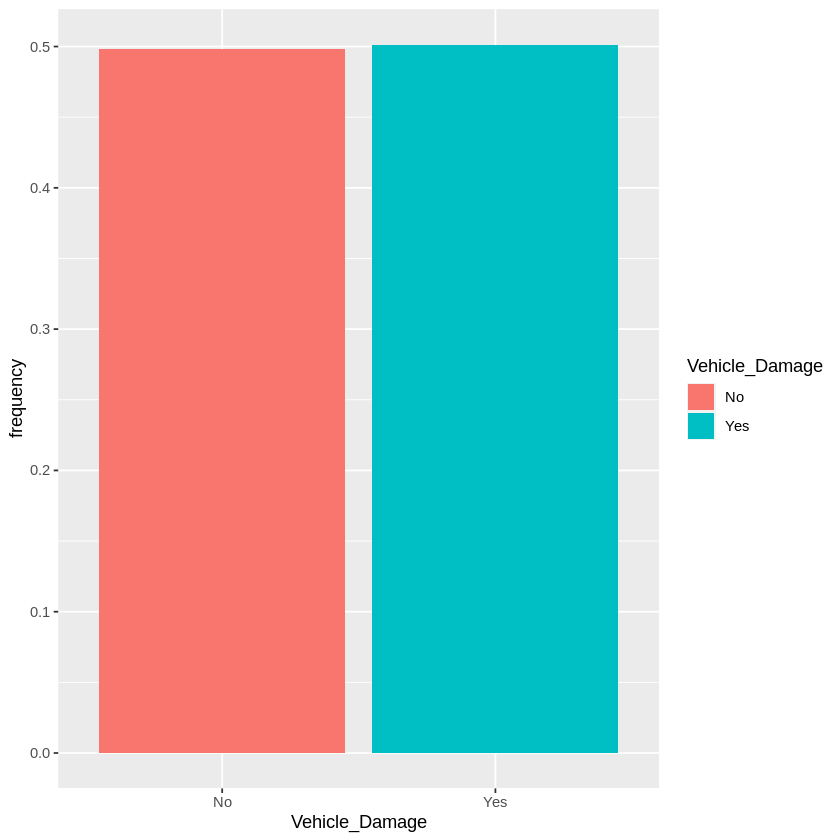

In [34]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Damage, fill = Vehicle_Damage)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab("frequency")

The variable is 
almost perfectly balanced, so no comments can be made

### 1.9. Annual_Premium

In [35]:
str(insurance.data$Annual_Premium)

 num [1:5000] 45016 40861 39897 42419 42038 ...


Numerical variable indicating the amount customer needs to pay as premium in the year

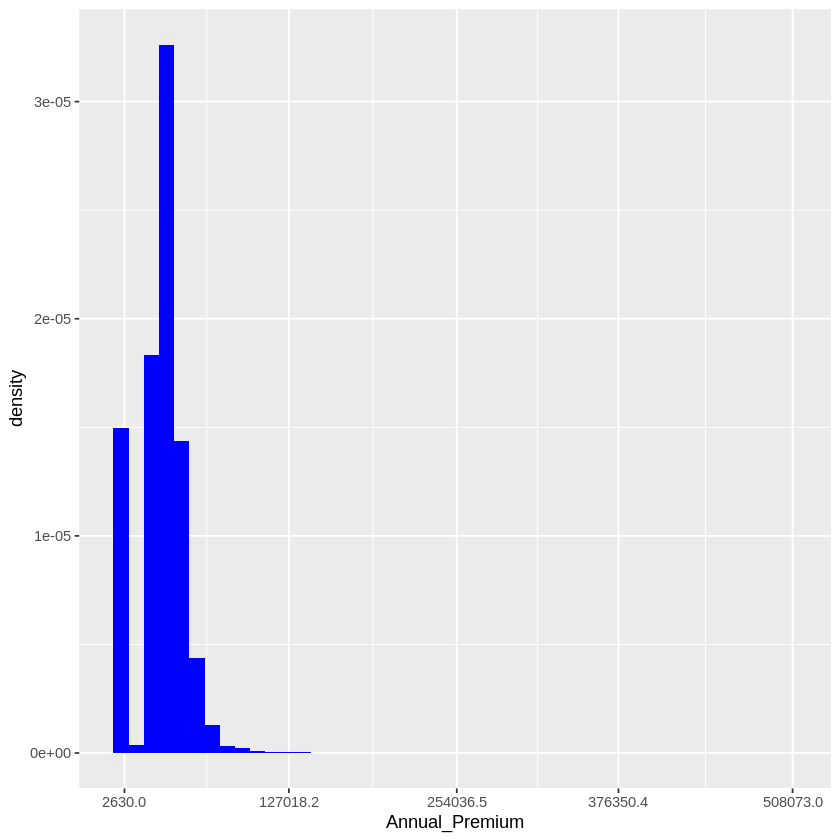

In [36]:
# get some break points for a better visualization of the x-axis
breaks.x <- c(
    min(insurance.data$Annual_Premium),
    max(insurance.data$Annual_Premium)/4,
    max(insurance.data$Annual_Premium)/2,
    max(insurance.data$Annual_Premium)/1.35,
    max(insurance.data$Annual_Premium))
    
insurance.data %>%
    ggplot(aes(x = Annual_Premium)) +
    geom_histogram(aes(y = ..density..),bins = 45, fill = "blue") +
    scale_x_continuous(breaks = breaks.x)

We can see that the most premium is in the interval $(2630,115000)$ with a really low number of people which falls out of that interval.

### 1.10. Policy_Sales_Channel

In [37]:
str(insurance.data$Policy_Sales_Channel)

 num [1:5000] 26 26 124 26 155 152 124 26 152 25 ...


This variable contains anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

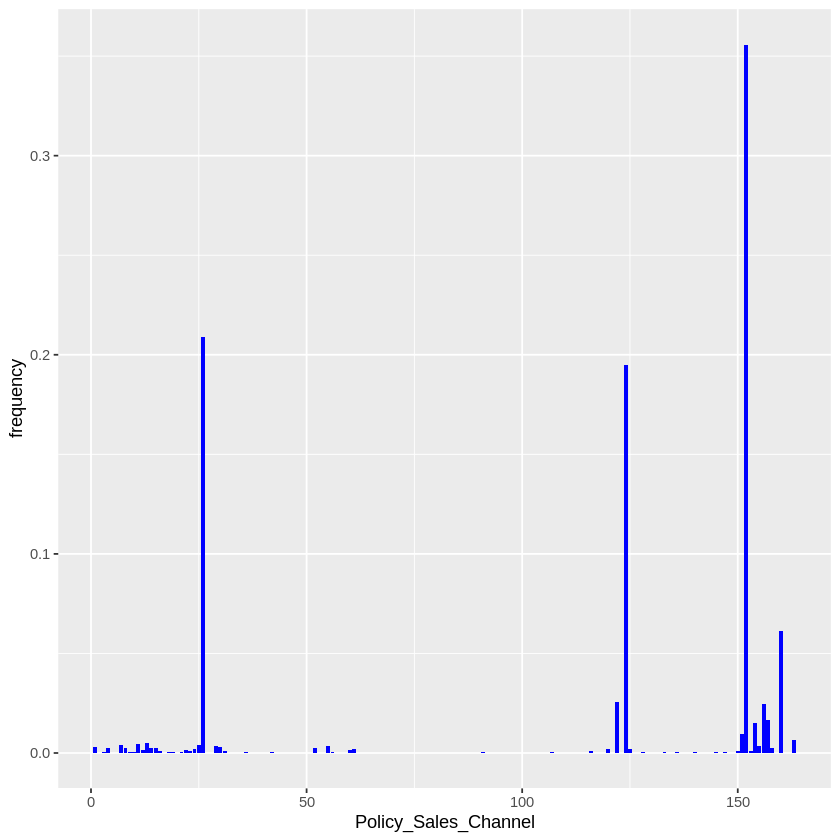

In [38]:
insurance.data %>%
    ggplot(aes(x = Policy_Sales_Channel)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),fill = "blue") +
    ylab("frequency")

There are few main policy sales channels, but due to the fact that there are no informations about what a channel refers to, we can't do any discussion.

### 1.11. Vintage

In [39]:
str(insurance.data$Vintage)

 int [1:5000] 244 31 126 112 65 39 289 295 125 258 ...


This variable contains the number of days a customer has been associated with the company. The fidelity of a person could be a nice bias in order to sign the contract. 

Let's see the distribution

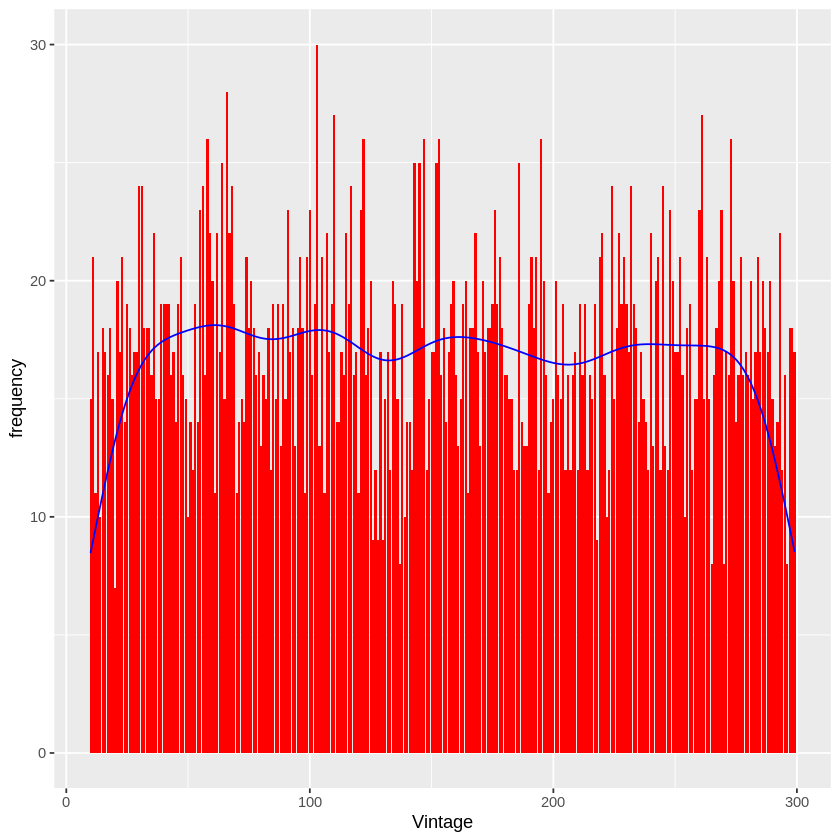

In [40]:
insurance.data %>%
    ggplot(aes(x = Vintage)) +
    geom_bar(aes(y = ..count..),fill = "red") +
    geom_density(aes(y = ..count..),color = "blue") +
    ylab("frequency")

The variable seems to be uniformly distributed.

Let's test this whit a significance level $\alpha = 0.05$.

In [41]:
install.packages("spgs")
scaled.vintage <- scale(insurance.data$Vintage, scale = T, center = F)
min <- min(scaled.vintage)
max <- max(scaled.vintage)
test <- spgs::chisq.unif.test(scaled.vintage, interval = c(min,max), bins = nrow(insurance.data))
test$p.value

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] 0.5040156

Since whe have that $p-value > \alpha = 0.05$ the test told us that we cannot reject the hypotesis that the variable is uniformly distributed!

We have that the dataset is equally distributed between fresh customers and older ones. But also the older ones are customers for less than one year!

### 1.12. Response

This is the label column, since we want do some unsupervised analysis we will delete without even looking at it since it could be an high bias on our analysis and choices.

In [42]:
insurance.data$Response <- NULL

<hr style="height:2px;border-width:0;color:black;background-color:black">

## <center> Variables Recap</center>

|#| Name | Type | Description |
|:-| :- | -: | :-: |
|1| [Gender](#1.2.-Gender) | Factor | Gender of the customer|
|2| [Age](#1.3.-Age) | Integer | Age of the customer |
|3| [Driving_License](#1.4.-Driving_License) | Factor | &emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>: Customer already has DL; <span style="color:red">**No**</span>: Customer does not have DL| 
|4| [Region_Code](#1.5.-Region_Code) | Integer | Unique code for the region of the customer |
|5| [Previously_Insured](#1.6.-Previously_Insured) | Factor | &emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>: Customer already has Vehicle Insurance;<span style="color:red">**No**</span>: Customer doesn't have Vehicle Insurance|
|6|[Vehicle_Age](#1.7.-Vehicle_Age)|Integer| Age of the Vehicle|
|7|[Vehicle_Damage](#1.8.-Vehicle_Damage)|Factor|&emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>:Customer got his/her vehicle damaged in the past;<span style="color:red">**No**</span>:Customer didn't get his/her vehicle damaged in the past|
|8|[Annual_Premium](#1.9.-Annual_Premium)|Numeric|The amount customer needs to pay as premium in the year|
|9|[Policy_Sales_Channel](#1.10.-Policy_Sales_Channel)|Integer|Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.|
|10| [Vintage](#1.11.-Vintage)|Integer|Number of Days the Customer has been associated with the company|

<hr style="height:2px;border-width:0;color:black;background-color:black">


## 2. Preparing the data

Before going on with our analysis we need to apply some transformations to the dataset.


### 2.1 Data Normalization

We have really different data ranges in our dataset, so we have to scale the data in order to make the future analysis indipendent from the scale of the data.

**NOTE**: this does not affect the data distributions seen above and their respective discussions.

In [43]:
# get the numeric variables
num_cols <- unlist(lapply(insurance.data, is.numeric))  

# scale the numeric variables
insurance.scaled <- insurance.data
insurance.scaled[,num_cols] <- as.data.frame(scale(insurance.data[num_cols],center = F, scale = T))

Let's show the new dataset

In [44]:
head(insurance.scaled)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,Male,1.4796986,Yes,0.9858197,Yes,1.1727872,No,1.2706236,0.2087430,1.3952392
2,Female,0.9307782,Yes,0.4759130,Yes,1.1727872,No,1.1533444,0.2087430,0.1772640
3,Male,0.7875815,Yes,0.9518260,No,0.5863936,Yes,1.1261345,0.9955435,0.7204924
4,Male,0.9785104,Yes,0.9518260,No,1.1727872,Yes,1.1973206,0.2087430,0.6404377
5,Male,1.1455731,Yes,0.9518260,No,1.7591809,Yes,1.1865665,1.2444294,0.3716826
6,Male,0.5966527,Yes,0.7818570,Yes,0.5863936,No,0.7101108,1.2203437,0.2230095


## 3. Correlation analysis

It's important to see if there is any kind of relations between variables.

### 3.1 Pearson's correlation

Let's start checking if there is correlation between numerical values.

First of all we will define a function to create a matrix of p-value according to the Pearons's linearity test, after we will calculate the Pearson's correlation matrix and the p-values matrix to check if there is a linear depencies between the variables. We will use a significativity level of $0.01$ to test our linearity correlation hipothesis. At the end we will show the results via an heatmap. In the next figure, correlations with p-value > 0.01 are considered as insignificant. In this case the correlation coefficient values are leaved blank and crosses are added.

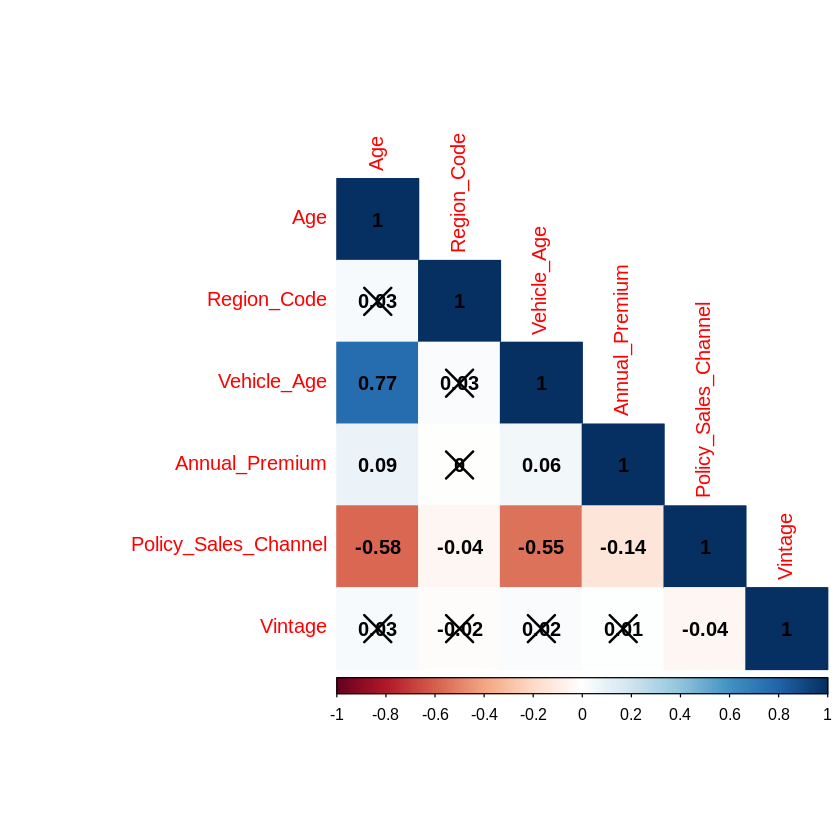

In [45]:
# a function to create a matrix filled by p-value of the correlation tests
cor.mtest <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    for (i in 1:n) {
        for (j in 1:n) {
            tmp <- cor.test(mat[, i], mat[, j], ...)
            p.mat[i, j] <- tmp$p.value
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  return(p.mat)
}

# calculate the correlation matrix
cor <- cor(insurance.scaled[,num_cols], method = "pearson")

# calculate the correlation p-value matrix
p.mat.pears <- cor.mtest(insurance.scaled[,num_cols])

# showing the correlation matrix with an heatmap
corrplot(cor, type = "lower", p.mat = p.mat.pears, sig.level = 0.01, method = "color",addCoef.col = "black")

One thing that we can see in the plot is that the vehicle age is positively correlated to the customers' age.

There is also a negative correlation between **policy_sales_channel** and **Age**, but since this is a non ordered categorical variable it makes no sense to consider that information, however if we had known that the policy_sales_channel has been chronologically ordered (the $i^{th}$ sales channel was added after the $(i-1)^{th}$ sales channel and before the $(i+1)^{th}$ sales channel) we had that newer (bigger value) sales channels work better with younger customers and older (lower value) sales channels work better with older customers!

Overall we can see that there are only few variables that are strongly linearly correlated.

Note that the Pearson correlation matrix shows only if two variables are **linearly** correlated, so makes sense study also other relationships based on our intuition in order to see if there are any non-linear correlation between data!

### 3.2 Cramer's V for correlation

Now let's apply the Chi-Square test to test if there is any form of correlation between categorical variables

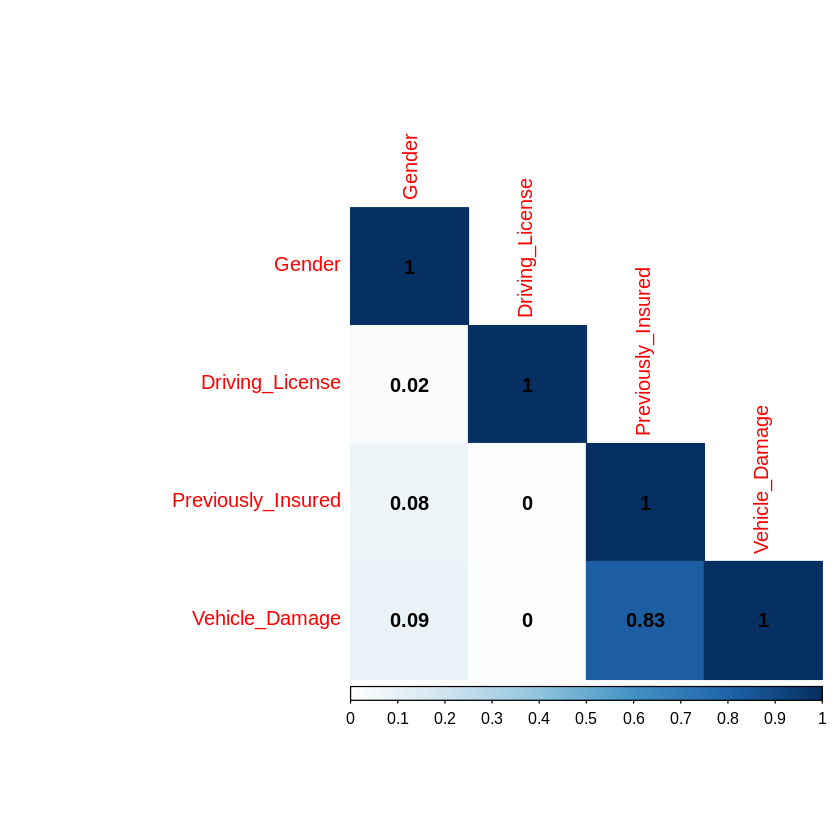

In [46]:
# a function to create a matrix filled by cramers value for the correlation
cram.cor <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    for (i in 1:n) {
        for (j in 1:n) {
            tmp <- assocstats(table(mat[,i],mat[,j]))
            p.mat[i, j] <- tmp$cramer
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  return(p.mat)
}

cram.matrix <- cram.cor(insurance.scaled[,!num_cols])

corrplot(cram.matrix, type = "lower", method = "color", is.corr = F, addCoef.col = "black")

Here we have plotted the cramers' values.

We can see that *gender* is weakly related with *Previously_Insured* and *Vehicle_Damage*, instead *Vehicle_Damage* is highly related to *Previously_Insured*!

### 3.3 Biserial correlation

Finally we will analyze if there is any form of correlation between mixed (numeric vs categorical) variables, we are going to to this by applying the Biserial correlation.

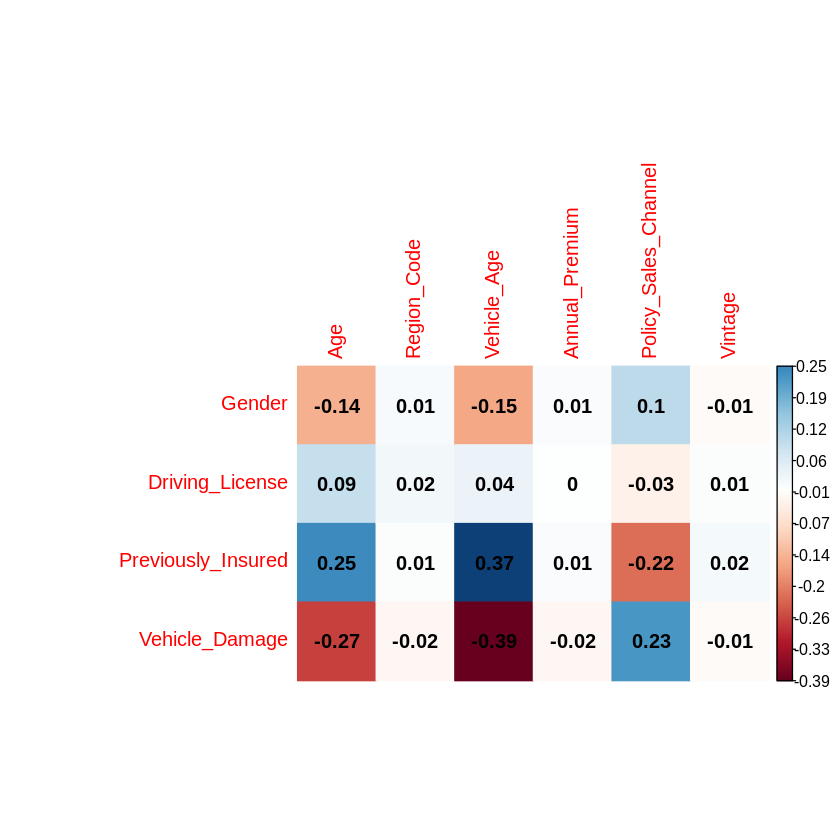

In [47]:
biserial.cormat <- function(mat1, mat2, ...) {
    n1 <- ncol(mat1)
    n2 <- ncol(mat2)
    p.mat <- matrix(NA, n1, n2)
    for (i in 1:n1) {
        for (j in 1:n2) {
            if(is.numeric(mat1[,i]) == T && is.factor(mat2[,j]) == T){
                tmp <- biserial.cor(x = mat1[,i], y = mat2[,j], use = "all.obs")
                p.mat[i, j] <- tmp
            }

        }
    }
  colnames(p.mat) <- colnames(mat2)
  rownames(p.mat) <- colnames(mat1)
  return(t(p.mat))
}

biserial.matrix <- biserial.cormat(insurance.scaled[,num_cols], insurance.scaled[,!num_cols])
corrplot(biserial.matrix,method = "color", is.corr = F, addCoef.col = "black")

Thanks to the Biserial correlation we can see that there is correlation between numerical and categorical variables, except *Region_Code*,*Annual_Premium* and *Vintage* that seem to are indipendent from all the categorical variables.

## 4. Multivariate analysis

We will analyze in depth the relationships between some interesting variables in order to have a better understanding about the data

### 4.1. Age~Vehicle_Age

Let's see a box plot that reppresent these two variables

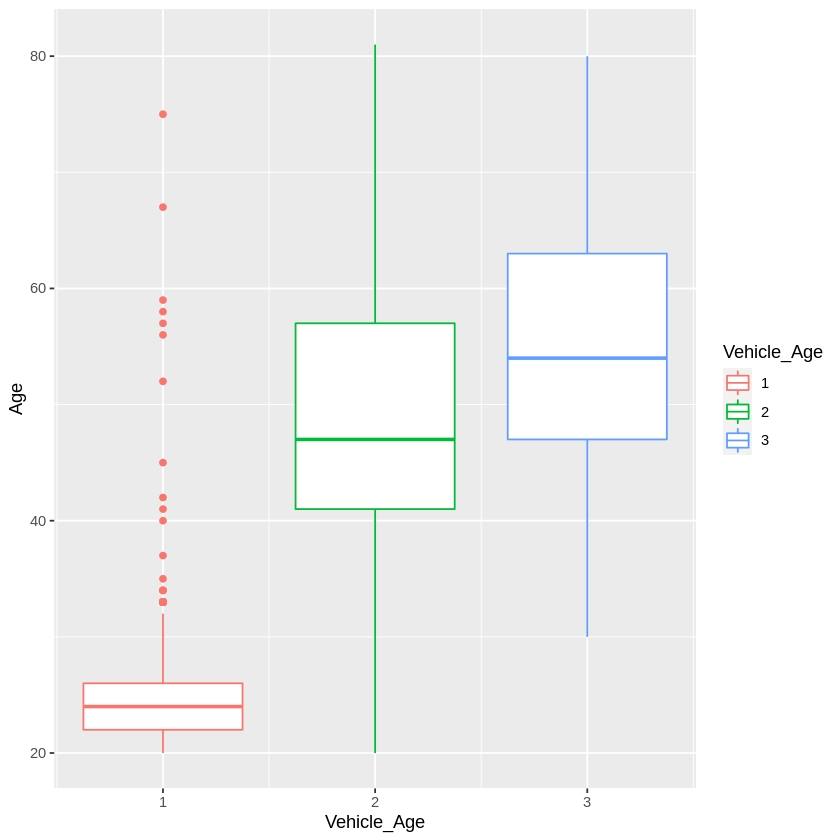

In [48]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Age, y = Age)) +
    geom_boxplot(aes(group=Vehicle_Age, colour = as.factor(Vehicle_Age))) +
    guides(color=guide_legend(title="Vehicle_Age")) 

Looking at the plot we can see that the newest cars ($< 1$ year) are driven by people between $20$ and $30$ years, the mid-age cars (between $1$ and $2$ years) are driven by mid-age people ($40-60$ years old) and the older cars are driven also by the mid-age people but few years older. According to the Vehicle Age [plot](#1.7.-Vehicle_Age) we know there are a really low number of old cars, so we have that the customers, in general, all have discrete security systems in their cars!

### 4.2. Age~Vehicle_Damage

It's important to see if people have their vehicles damaged with a certain relation to their ages.

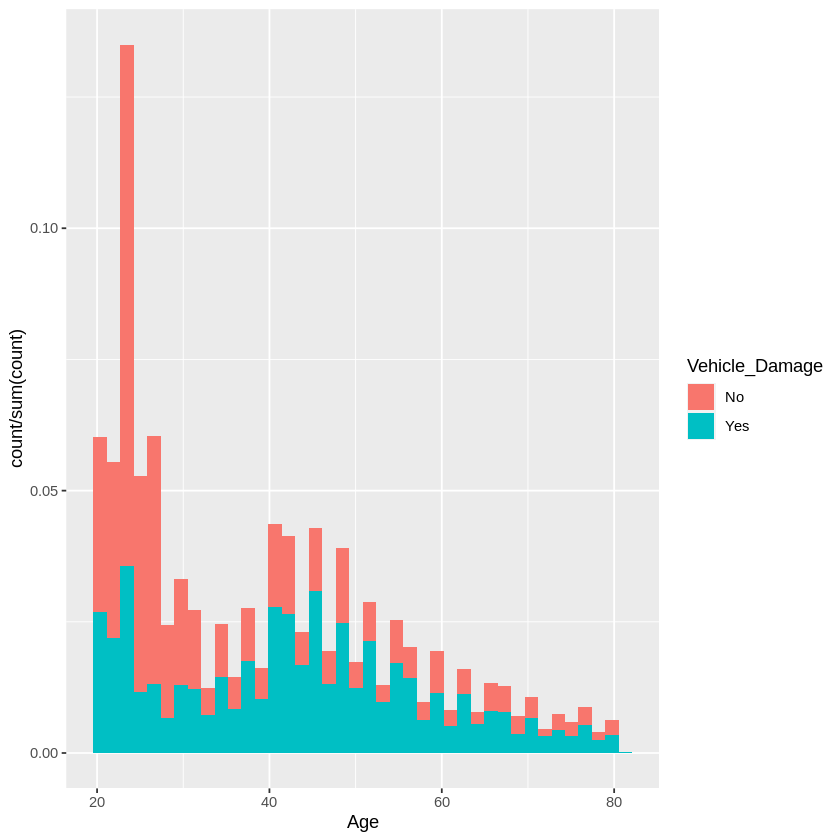

In [49]:
insurance.data %>%
    ggplot(aes(x = Age)) +
    geom_histogram(aes(y = ..count../sum(..count..),fill = Vehicle_Damage), bins = 40)

Thanks to the plot we know that in general people tend to not have their vehicle damaged. We have also that youger people are more cautious than older ones. We can also see that the differences between red (no damages) and blue (damaged cars) bars become lower and lower at the increasing of the age.

### 4.3. Vehicle_Age~Vehicle_Damage

We already know that there is a certain form of relation between these data, this could be due the more a car is driven the more are the probability to get damaged.

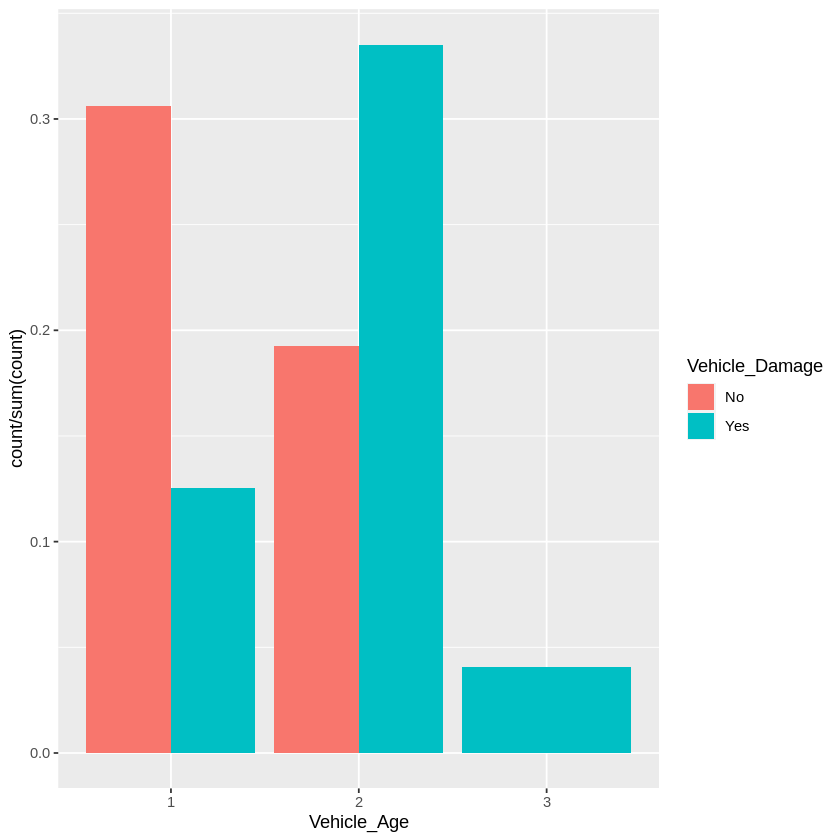

In [50]:
insurance.data %>%
    ggplot(aes(x = as.factor(Vehicle_Age))) +
    geom_bar(aes(y =..count../sum(..count..), fill = Vehicle_Damage), position = "dodge") +
    xlab("Vehicle_Age")

The plot seems to accord our expectations, since we can see that the proportion of damaged cars increase at the increasing of the age of the cars

### 4.4. Age~Annual_Premium

According to the two discussions above, it is reasonable to think that older people, having on average older cars, are more at risk of accidents than younger people. Hence, let's see if the age is a relevant factor on the calculation of the annual premium

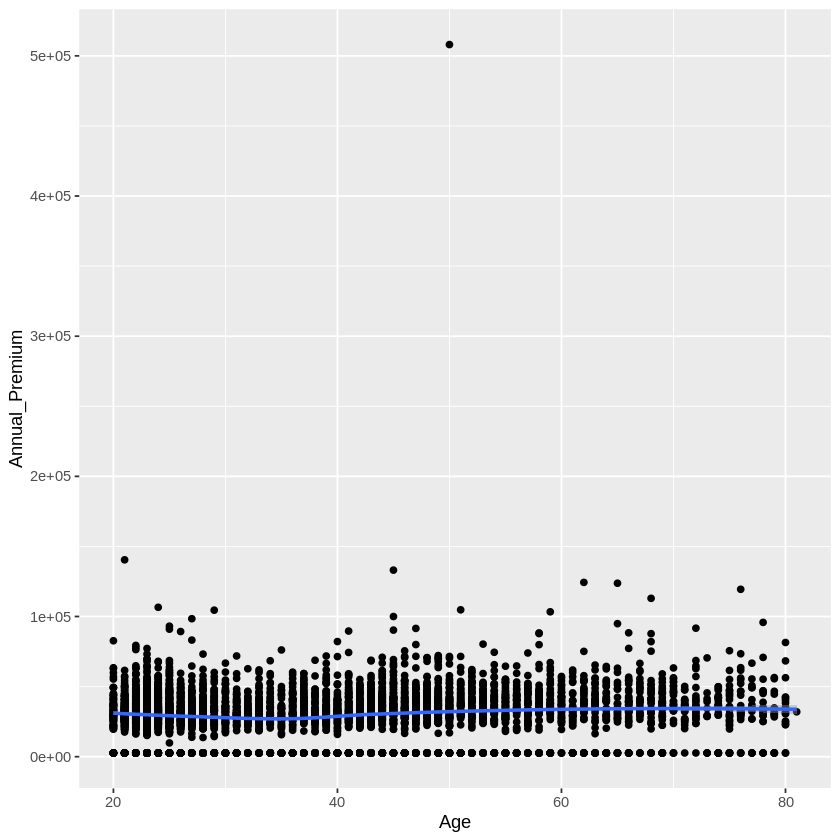

In [51]:
insurance.data %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

No relations seems to be between these two features, since the annual premium is pretty equal distributed between ages. Since there are a lot of data could be difficult to see some relations, let's try to plot a random k-sample of the data

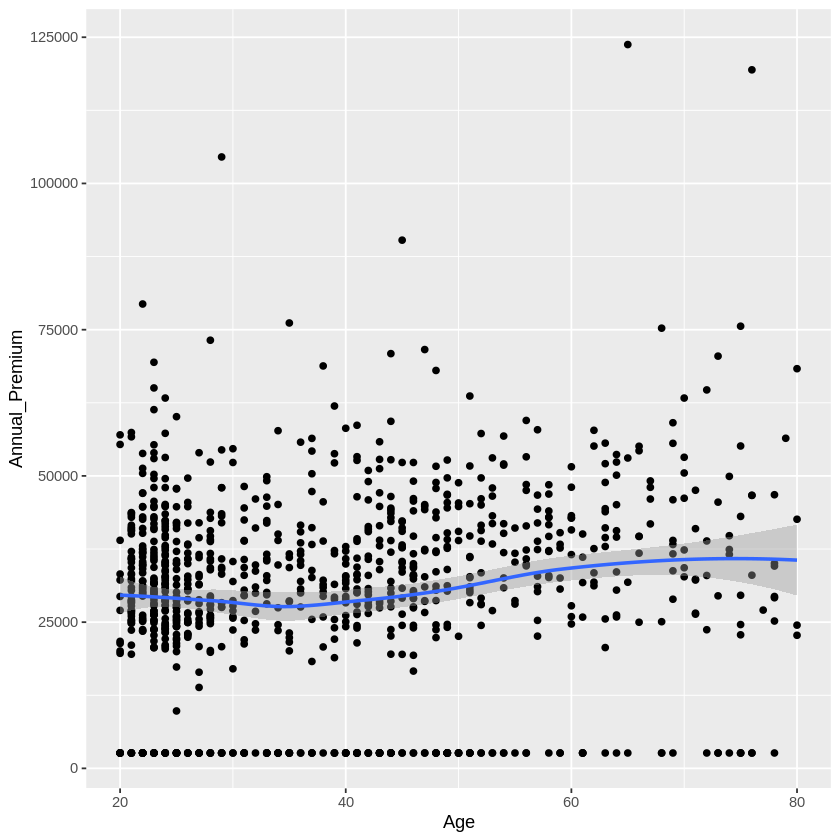

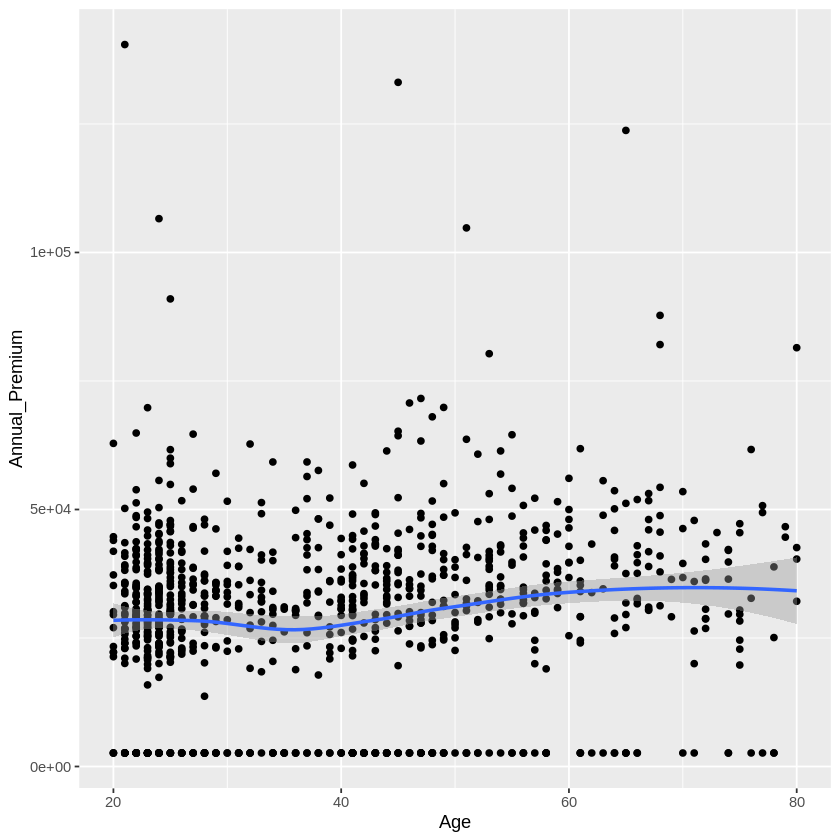

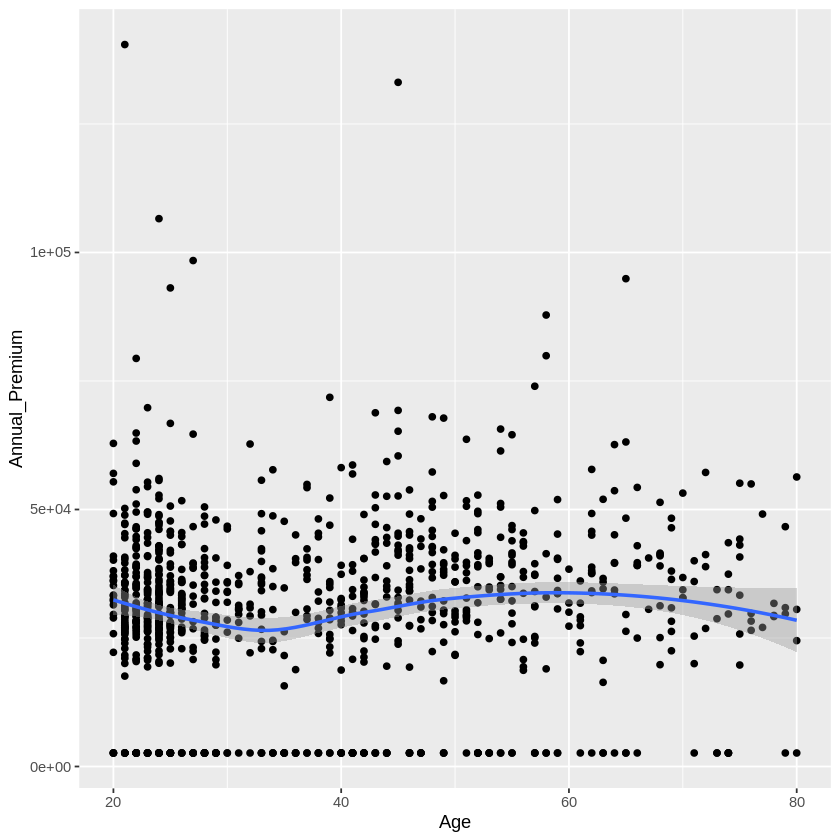

In [52]:
# define k, the dimension of the sample
k = 1000

# get the k-dimensional sample
sample1 <- sample(1:nrow(insurance.scaled), k)
sample2 <- sample(1:nrow(insurance.scaled), k)
sample3 <- sample(1:nrow(insurance.scaled), k)

#plot the samples
insurance.data[sample1, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

insurance.data[sample2, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

insurance.data[sample3, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

After we have plotted different samples nothing seems to appear, so we can think that the customer's age is not a determinant variable to the annual prize!

### 4.5. Vehicle_Age~Annual_Premium

Let's see how the vehicle age influence the annual premium. Since the Annual_Premium variable is a continuous variable with a really large range, we will delete the last part due to the fact that there are really low samples with an annual premium greather than $100,000\$$

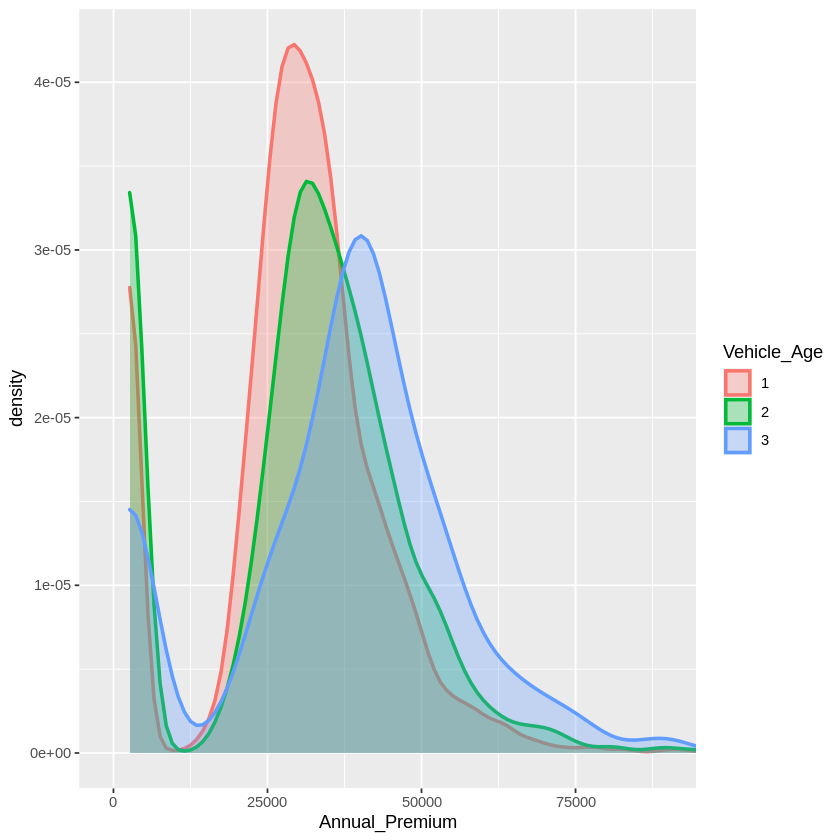

In [53]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,fill = as.factor(Vehicle_Age), color = as.factor(Vehicle_Age))) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(-1000,90000)) +
    guides(color=guide_legend(title="Vehicle_Age"), fill=guide_legend(title="Vehicle_Age"))

We can see that there are a lot of sample with the lower annual price, indipendently from the vehicle age, but leaving these "marginal" points we can see a slighty difference between the premium according to the vehicle ages, the premium increase at the incrasing of the age.

### 4.6. Vehicle_Damage~Annual_Premium

We expect that if a vehicle got damaged the annual premium increase, but let's see if this really happens

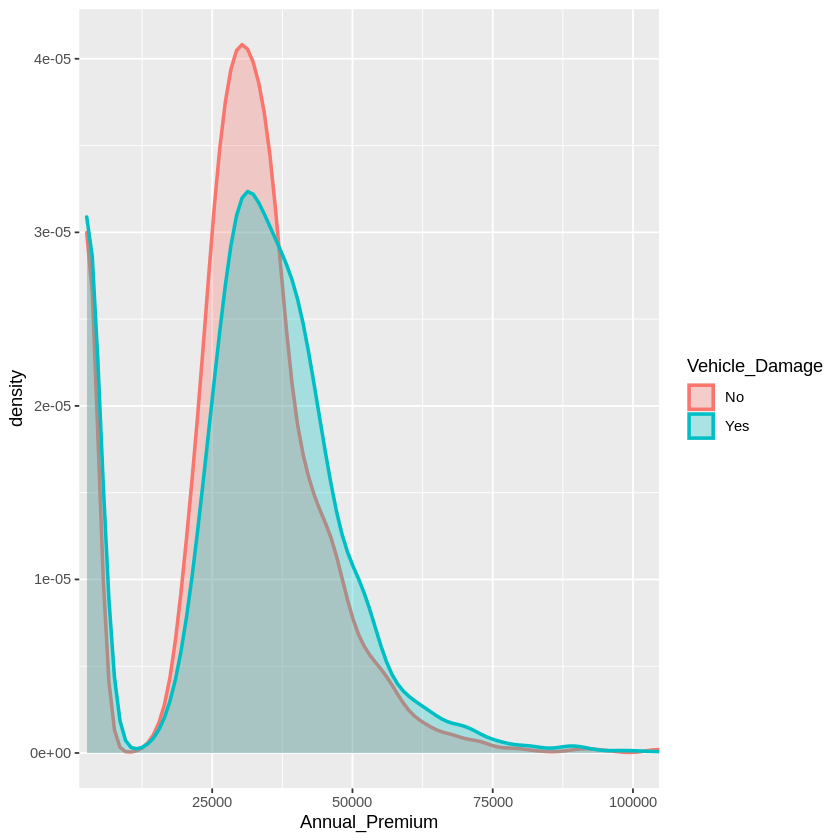

In [54]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,color = Vehicle_Damage, fill = Vehicle_Damage)) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(6000,100000))

As we can see, the damage have not a significat weight on the calculation of the annual premium, if a car is damaged there are only few more probability to pay an higher premium. We can say that by looking at the small right shifting of the Damaged Vehicle distribution but in average people pay the same amount for the annual premium indipendently if the vehicle is damaged or not.

### 4.7. Vehicle_Age~Vehicle_Damage-Annual_Premium

Since both Vehicle_Age and Vehicle_Damage variables seems to give a limited contribute to the annual prize, let's see how this two variables contribute together

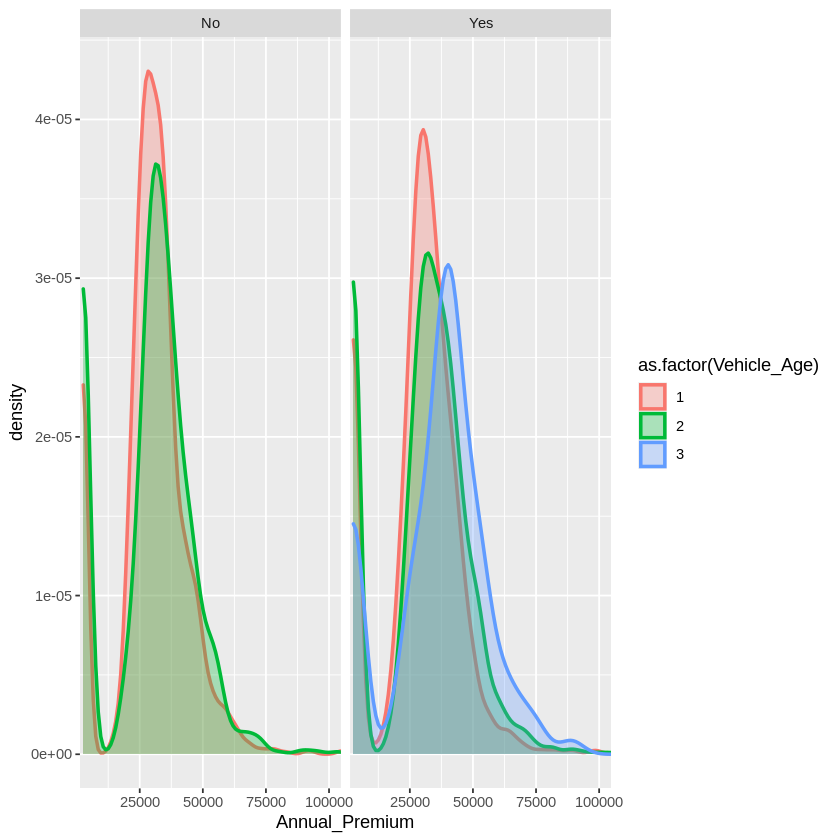

In [55]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,color = as.factor(Vehicle_Age), fill = as.factor(Vehicle_Age))) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(6000,100000)) +
    facet_wrap(~Vehicle_Damage)

Thanks to this plot we can see an interesting fact:

- There are no old (>2 years; blue bell) cars without damages;

- A person with an older car and with no damage is awarded in the annual premium rather than the youger car, instead if a person with an old car got his car damaged, then the annual premium become, in general, higher than the newest cars!

## 5. Principal Components Analysis

It is important to understand the variablity of the data, to do so we will apply the Principal Component Analysis in order to check out which variables explains more variablity.

We are going to apply the PCA only on the numeric variables

In [56]:
# calculate pca
pca <- prcomp(insurance.scaled[,num_cols], scale. = F, center = F)

# show some informations
(summary.pca <- summary(pca))

pca

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6
Standard deviation     2.2449 0.56378 0.49099 0.46754 0.39280 0.16950
Proportion of Variance 0.8399 0.05297 0.04018 0.03643 0.02572 0.00479
Cumulative Proportion  0.8399 0.89288 0.93306 0.96950 0.99521 1.00000

Standard deviations (1, .., p=6):
[1] 2.2448747 0.5637782 0.4909927 0.4675416 0.3928028 0.1694958

Rotation (n x k) = (6 x 6):
                            PC1        PC2        PC3         PC4        PC5
Age                  -0.4213697  0.4551953 -0.1776451 -0.08181229  0.3306227
Region_Code          -0.4083519 -0.1182395 -0.1530117 -0.64544084 -0.6157924
Vehicle_Age          -0.4260222  0.3708856 -0.1725153 -0.08814263  0.3372792
Annual_Premium       -0.3983040  0.1518970  0.8607626  0.20218235 -0.1909182
Policy_Sales_Channel -0.3911445 -0.7720081  0.0840937 -0.09106464  0.4828106
Vintage              -0.4031890 -0.1489677 -0.4090038  0.72095303 -0.3580158
                              PC6
Age                   0.683873142
Region_Code           0.007842252
Vehicle_Age          -0.727778204
Annual_Premium       -0.006438176
Policy_Sales_Channel  0.050387311
Vintage               0.003818338

Thanks to this summary we can see that with the first 2 cover aproximately $90\%$ of the variability!

But let's analyze it graphically

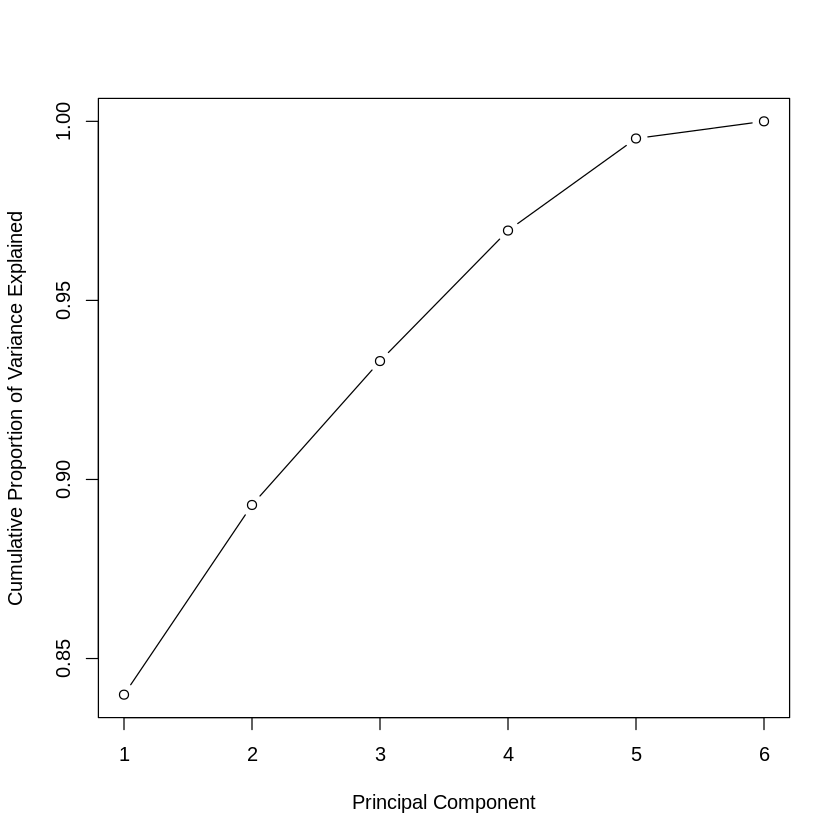

In [57]:
plot(summary.pca$importance[3,], xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     type = "b")

We will take only the first $2$ Principal components and leave all the others.

Let's plot the dataset in this new set of variables.

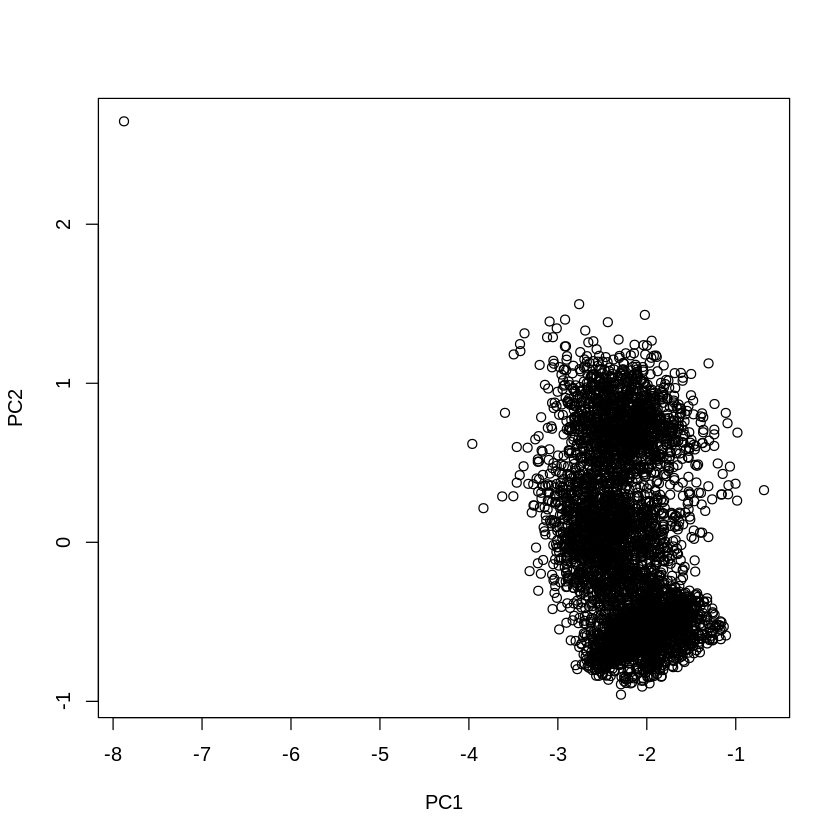

In [58]:
# get the first 2 Principal components
pc.data <- as.data.frame(pca$x[,1:2])

# plot the data
plot(pc.data)

Thanks to this plot we can see that, in the new space, there are at least two separate group of customers. The first group could be the one with $PC2 <= -0.5$ and the other points going into the second one


We could also think to separate the data into 3 groups only based on the second Principal Component.
Let's check out the contribute of each variable to each Principal Component.

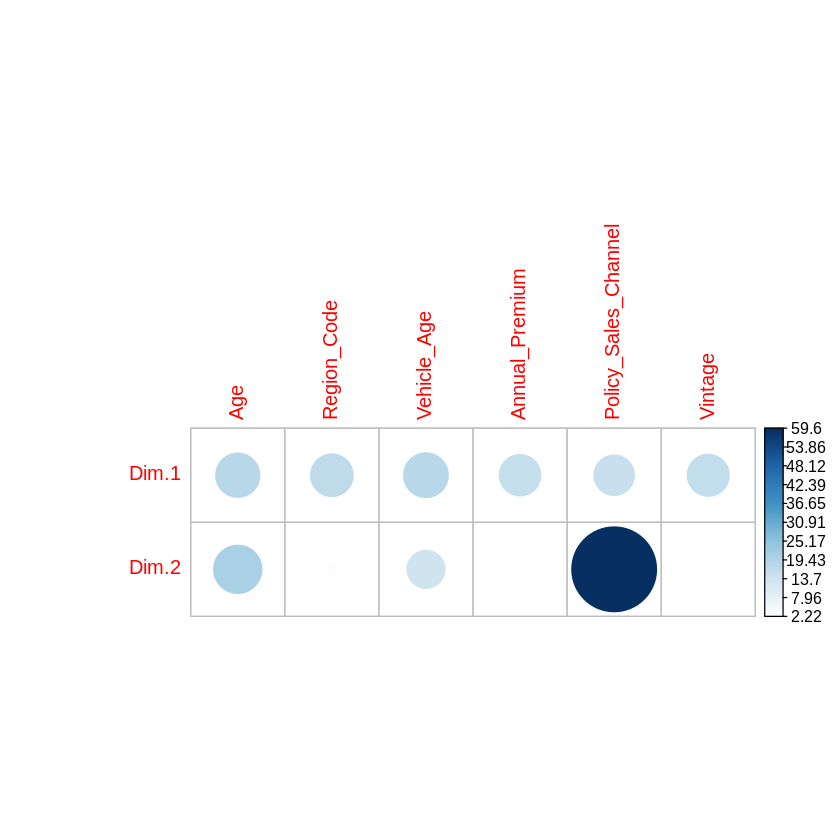

In [59]:
var <- get_pca_var(pca)

corrplot(t(var$contrib[,1:2]), is.corr=FALSE)

As we can see the second Principal Component is mainly determined by *Age*, *Vehicle_Age* and *Policy_Sales_Channel* and we know that this variables are correlated each other. Instead the first principal component is pretty equally composed by all the variables.

Thanks to the plot above and the heatmap we have just discussed, we can see that the second Principal Component is pretty well clustered, but looking at the first principal component, which is composed by all the variables, we can see that the most part of the samples form some *clouds of points* but there are also some samples standing outside these clouds.

Let's analyze the two Principal Components separately

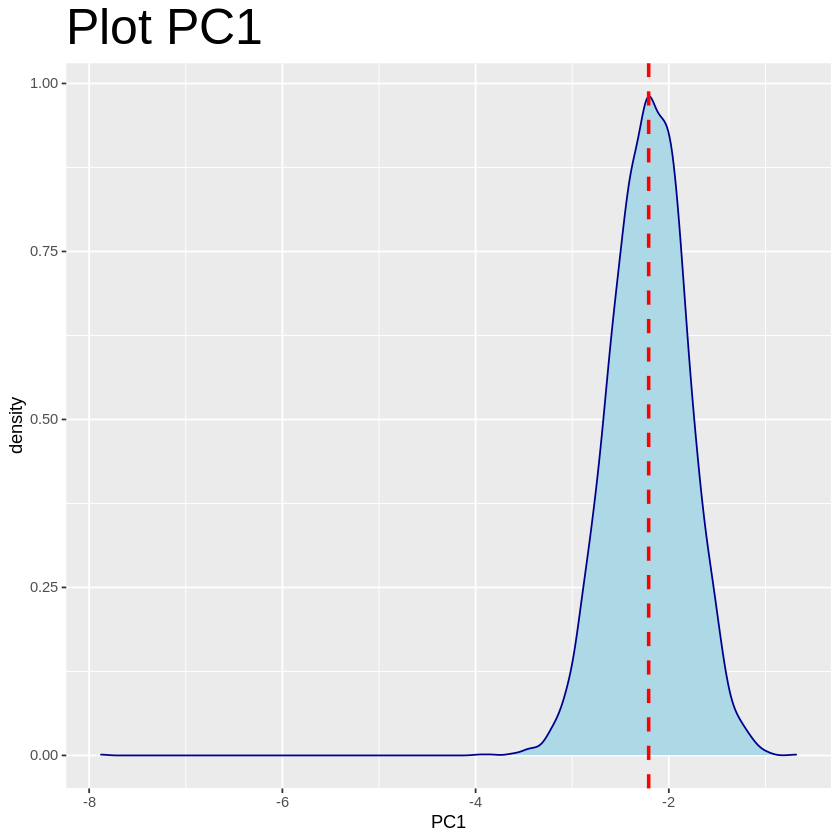

In [60]:
pc.data %>% 
    ggplot(aes(PC1)) + 
    geom_density(color = "darkblue", fill = "lightblue") +
    geom_vline(aes(xintercept=mean(PC1)), color = "red", linetype = "dashed", size = 1) +
    ggtitle("Plot PC1") +
    theme(plot.title = element_text(size = 30))

As we saw in the scatterplot the first Principal Component follow a normal distribution with a little right skewness.

Now it's time to look at the second Principal Component.

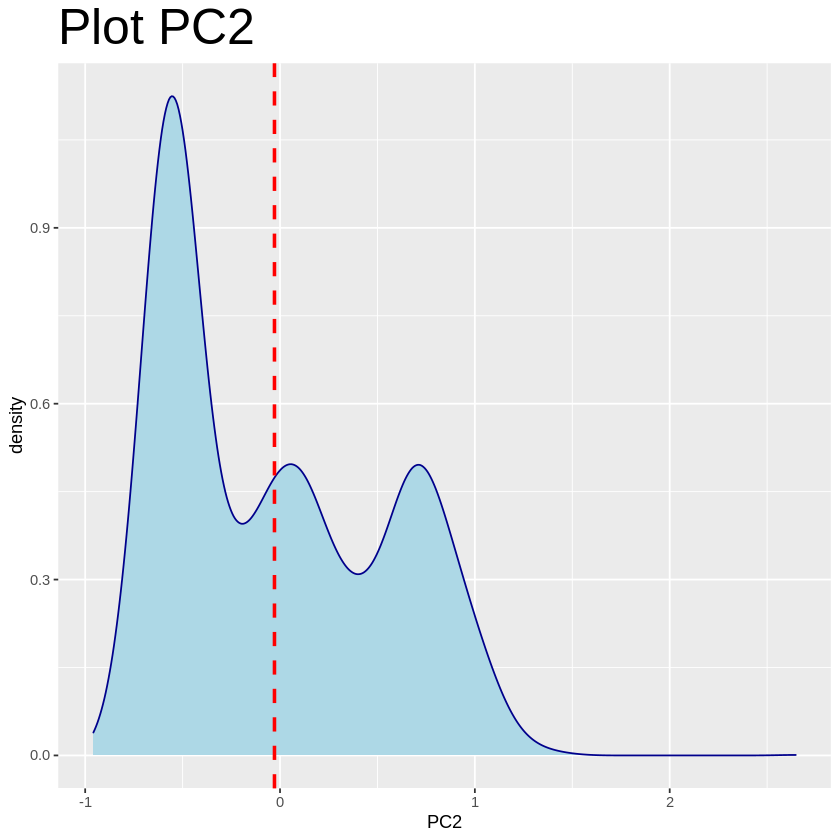

In [61]:
pc.data %>%
    ggplot(aes(PC2)) +
    geom_density(color = "darkblue", fill = "lightblue") +
    geom_vline(aes(xintercept=mean(PC2)), color = "red", linetype = "dashed", size = 1) +
    ggtitle("Plot PC2") +
    theme(plot.title = element_text(size = 30))

Here we can see three different peaks, these are the three potential clusters we said before.

## 6. Outlier Detection

It could be interesting to study the first principal component in order to check out if these outliers are there due to noise on the data or these are some interesting points.

### 6.1 Hampel filter

Here we will apply a smoother version of the Hampel filter to the first Principal Component hoping that this technique can identify the right samples.

This is an outlier detection technique, it consists of considering as outliers the values outside the interval ($I$) formed by the median, plus or minus 3 times the median absolute deviations($MAD$): $$I = [median - 2.5\cdot MAD; median-2.5\cdot MAD]$$

where MAD is the median absolute deviation and is defined as the median of the absolute deviations from the data’s median $\tilde{X}=median(X)$ 

$$MAD = median(|X_i - \tilde{X}|)$$

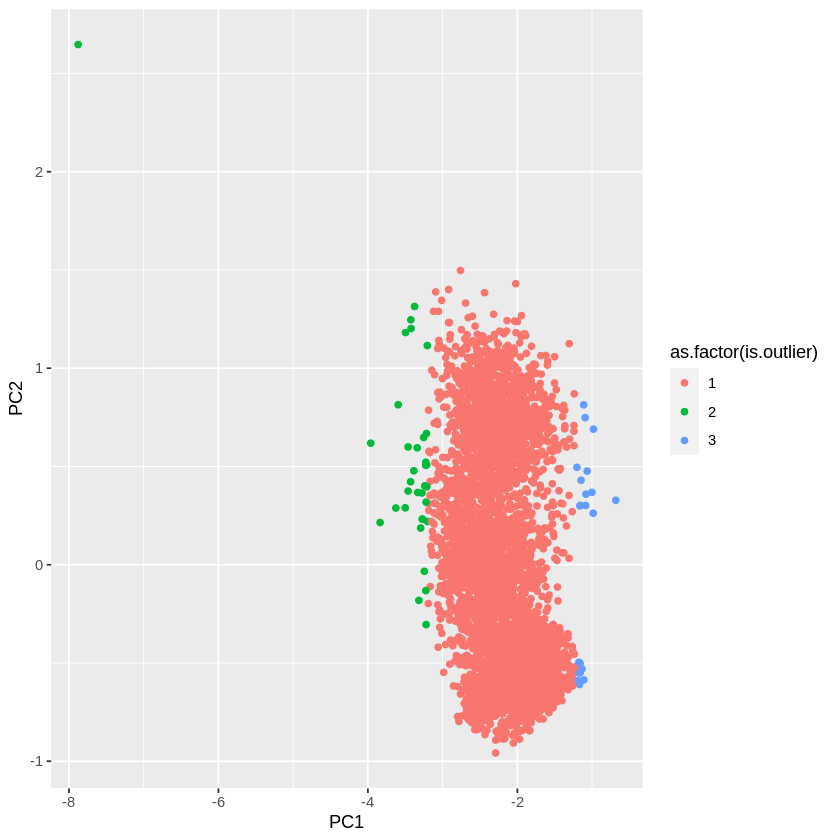

In [62]:
# calculate the lower bound
lower_bound <- median(pc.data$PC1) - 2.5 * mad(pc.data$PC1)

# calculate the upper bound
upper_bound <- median(pc.data$PC1) + 2.5 * mad(pc.data$PC1)

# get the outliers indexes
left_outlier_ind <- which(pca$x[,1] < lower_bound)
right_outlier_ind <- which(pca$x[,1] > upper_bound)

# creating a copy of the data
hampel.data <- pc.data

# set the sampler as outlier
hampel.data$is.outlier <- 1:nrow(hampel.data)

hampel.data$is.outlier[-left_outlier_ind] = 1 #no outliers
hampel.data$is.outlier[left_outlier_ind] = 2 # < lower_bound
hampel.data$is.outlier[right_outlier_ind] = 3 # > upper_bound

hampel.data$is.outlier <- as.factor(hampel.data$is.outlier)

# plot the new data
colVar <- sapply(hampel.data$is.outlier, function(a){ifelse(a == 1,'red', ifelse(a == 2,'green', 'blue'))})
colVar <- factor(colVar,levels=c('red','green','blue'))

hampel.data %>% ggplot(aes(PC1,PC2, color = as.factor(is.outlier))) + geom_point()

We caught most of the left side and right side outliers! Let's analyze both the groups.

Warning message:
“attributes are not identical across measure variables;
they will be dropped”
Picking joint bandwidth of 0.0528



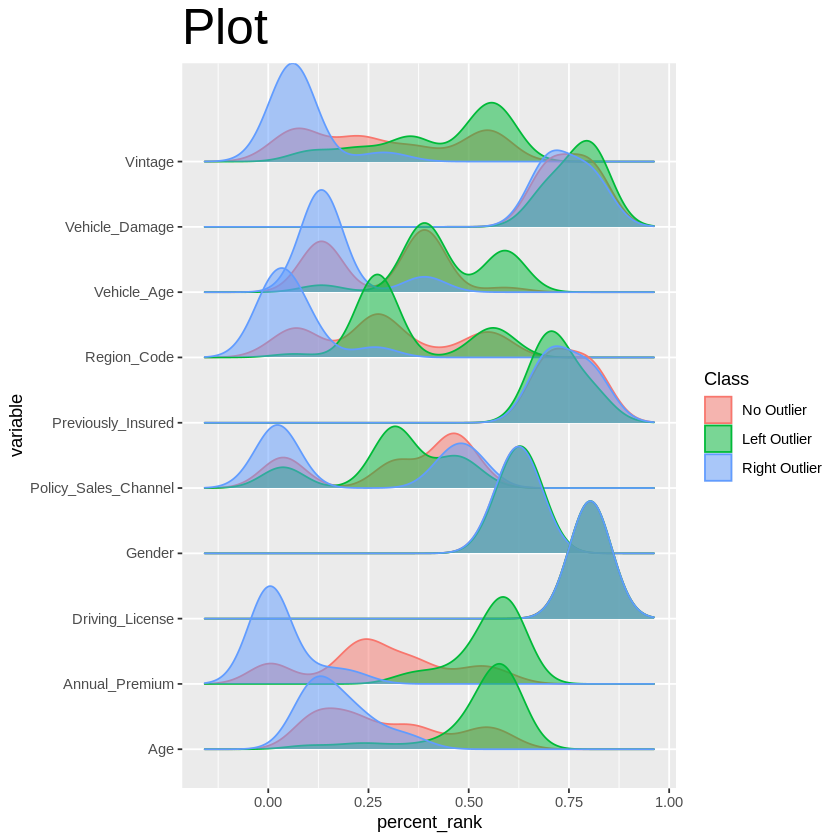

In [63]:
temp.data <- as.data.frame(insurance.scaled)
temp.data$class <- hampel.data$is.outlier

temp.data %>%
    gather(variable, value, -class) %>%
    ggplot(aes(y = as.factor(variable),
              fill = class,
              color = class,
              x = percent_rank(value))) +
    geom_density_ridges(alpha = 0.5) +
    xlab("percent_rank") +
    ylab("variable") +
    scale_fill_discrete(name = "Dose", labels = c("No Outlier", "Left Outlier", "Right Outlier")) +
    scale_color_discrete(name = "Dose", labels = c("No Outlier", "Left Outlier", "Right Outlier")) +
    guides(fill=guide_legend(title="Class"), color=guide_legend(title="Class")) +
    ggtitle("Plot") +
    theme(plot.title = element_text(size = 30))

We can see that *Gender* and *Driving_License* are pretty equal in the three classes. We also have that the left outliers are, in general, old people who have been customers of the company for long time driving old cars and got offered a very high annual premium. The right outliers are exactly the opposite of the left outliers!

The *Policy_Sales_Channel* and *Region_Code* seems to be two others crucial variables to the outliers.

## 7. Cluster Analysis

In this chapter we will carry out some significant clusters on the dataset (if any).

### 7.1 Clustering tendency

Before going on the cluster analysis we have to assert that the dataset contains meaningful clusters or not. To do that we will use the hopkins statistic and the VAT Algorithm for a graphical representation.

#### 7.1.1 VAT Visual Assessment of cluster Tendency

First of all we will analyze the VAT results.

In [64]:
# calculate the gower distance matrix
dist <- as.dist(gower.dist(insurance.scaled))

# VAT
#fviz_dist(dist, show_labels = F, gradient = list(low = "black", mid = "white", high = "white"))

The VAT algorithm shows up that the data seems pretty well clustered since there are some *large squares* into the first diagonal of the VAT plot.

#### 7.1.2 Hopkins Statistic

Even if the VAT told us that the dataset was clustered we will apply a statistical test, the **Hopkins Statistic** to have a numerical value of the cluster tendency of the dataset.
The Hopkins Statistic is a statistical way to measure the cluster tendency of a dataset, it will take values in $[0,1]$. Since the dataset is composed by categorical and numeric variables we have to use the gower distance, hence we cannot apply the pre-built R function for the Hopkins statistic but we have to create it by scratch. 
 
 First of all we will define all the functions which allow us to compute the Hopkins Statistic.

In [65]:
# function to create the sampled dataset
create.sampled.data <- function(m, X){
  Y.indexs <- sample(1:nrow(X), m)
  Y <- X[Y.indexs,]
}

# function to create the random artificial dataset
create.artificial.data <- function(m, X){
  Gender <- as.factor(sample(c("Male", "Female"), m, replace = T, prob = c(0.5,0.5)))
  Age <- runif(m, min = min(X$Age), max = max(X$Age))
  Driving_License <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Region_Code <- runif(m, min = min(X$Region_Code), max = max(X$Region_Code))
  Previously_Insured <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Vehicle_Age <- runif(m, min = min(X$Vehicle_Age), max = max(X$Vehicle_Age))
  Vehicle_Damage <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Annual_Premium <- runif(m, min = min(X$Annual_Premium), max = max(X$Annual_Premium))
  Policy_Sales_Channel <- runif(m, min = min(X$Policy_Sales_Channel), max = max(X$Policy_Sales_Channel))
  Vintage <- runif(m, min = min(X$Vintage), max = max(X$Vintage))

  # put all together in a dataset
  Z <- data.frame(Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage)
  return(Z)
}

# function to calculate distances
calc.dist <- function(X, Y, m, is.original = T){
  YX.dists <- 0
  if(is.original == T){
    for(i in 1:m){
      # X[rownames(X) != rownames(Y[i,])[1],] allows us to avoid the distance
      #                                       between a row with itself
      YX.dists <- YX.dists + min(gower.dist(Y[i,], X[rownames(X) != rownames(Y[i,])[1],]))
    }
  }
  else {
    for(i in 1:m){
      YX.dists <- YX.dists + min(gower.dist(Y[i,], X))
    }
  }
  return(YX.dists)
}

# function to calculate hopkins statistic
my.hopkins <- function(X, m){
  Y <- create.sampled.data(m, X)
  Z <- create.artificial.data(m, X)
  YX.dist <- calc.dist(X, Y, m, T)
  ZX.dist <- calc.dist(X, Z, m, F)
  H <- YX.dist / (ZX.dist + YX.dist)
  
  return(H) 
}

Now we will apply the Hopkins statistic to our dataset with $m = 4000$ (we will generate the two datasets with $m$ rows)

In [66]:
m <- 4000
#my.hopkins(insurance.scaled, m)

We got a really nice value for the test, $0.1$, it means that the dataset is well clusterable and our discussions about the VAT algorithm were right! 

### 7.2 Optimal number of clusters & Best clustering method

Now that we know that the dataset is clusterable we have to check out the best number of clusters.
We will compute some different clustering algorithm and evaluatig some plots and statistics in order to check out the best combination: **Number of clusters ~ Algorithm**.

We will analyze the following Clustering Algorithms:
  * PAM
  * Hierarchical (with different configurations)
  * DBScan

And we will use the following metrics:
  * Elbow method
  * Average Silhouette method
  * Dunn index
  * GAP statistic

#### 7.2.1 PAM Partitioning Around Medoid

The PAM algorithm is generalization of k-means using any distance measure and using elements of the data as centroid (in PAM these are called medoids).

Since PAM doesn't use the **WSS** metric we have to build the WSS by our own.

In order to use the GAP statistic we have to build our function, because the pre-built function doesn't allow categorical data.

Let's write the functions to compute *WSS*, *Elbow Method*,  and *GAP Statistic* respectively.


In [116]:
calc.wss <- function(clustering){
  WSS <- t(clustering$clusinfo[,3]) %*%  clustering$clusinfo[,1]
  return(WSS)
}
# elbow function
pam.elbow <- function(dist, K){
  elbow <- c()
  for (i in 1:K){
    pam_fit <- pam(dist, diss = T, k = i)
    elbow[i] <- calc.wss(pam_fit)
  }
  plot(1:K, elbow, 
    xlab = "Number of clusters",
    ylab = "WSS",
    main = "WSS Plot")
  lines(1:K, elbow)
}

step1 <- function(dist, K){
  # step 1
  obj.fun <- c()
  for (k in 1:K){
    pam_fit <- pam(dist, diss = T, k = k)
    obj.fun[k] <- calc.wss(pam_fit)
  }
  return(obj.fun)
}

step2 <- function(dist, data, m, B, K){
  # step 2
  art.obj.fun <- matrix(list(), nrow = B, ncol = K)
  for (b in 1:B){
    artificial.data <- create.artificial.data(m, data)
    for(k in 1:K){
      pam_fit <- pam(as.dist(gower.dist(artificial.data)), diss = T, k = k)
      art.obj.fun[[b, k]] <- calc.wss(pam_fit)#pam_fit$objective[1]
    }
  }
  return(art.obj.fun)
}

step3 <- function(B, K, obj.fun, art.obj.fun){
  #step 3
  gap <- c()
  for(k in 1:K){
    sum.obj.fun <- 0
    for (b in 1:B){
      sum.obj.fun <- sum.obj.fun + log(art.obj.fun[[b, k]])
    }
    gap[k] <- 1/B * sum.obj.fun - log(obj.fun[k])
  }
  plot(1:K, gap,
     xlab = "Number of clusters",
     ylab = "Silhouette Width",
     main = "Gap Plot")
  lines(1:K, gap)
  return(gap)
}

step4 <- function(B, K, art.obj.fun, gap){
  for(k in 1:(K-1)){
    sd <- 0
    mean <- 0
    for(b in 1:B) {
      mean <- mean + log(art.obj.fun[[b, k + 1]])
    }
    mean <- 1/B * mean
    intern <- 0
    for(b in 1:B){
      intern <- intern + ((log(art.obj.fun[[b, k + 1]]) - mean ) ** 2)
    }
    sd <- sqrt( 1/B * intern )
    s <- sqrt(1 + 1/B) * sd
    if (gap[k] >= gap[k+1] - s) {
      return(k)
    }
  }
  return(K)
}
# GAP function
pam.GAP <- function(dist, data, m, B, K){
  step1(dist = dist, K = K) -> obj.fun
  step2(dist = dist, data = data, m = m, B = B, K = K) -> art.obj.fun
  step3(B = B, K = K, obj.fun = obj.fun, art.obj.fun = art.obj.fun) -> gap
  step4(B = B, K = K, art.obj.fun = art.obj.fun, gap = gap) -> k
  return(k)
}

According to the GAP statistic method k =: 6




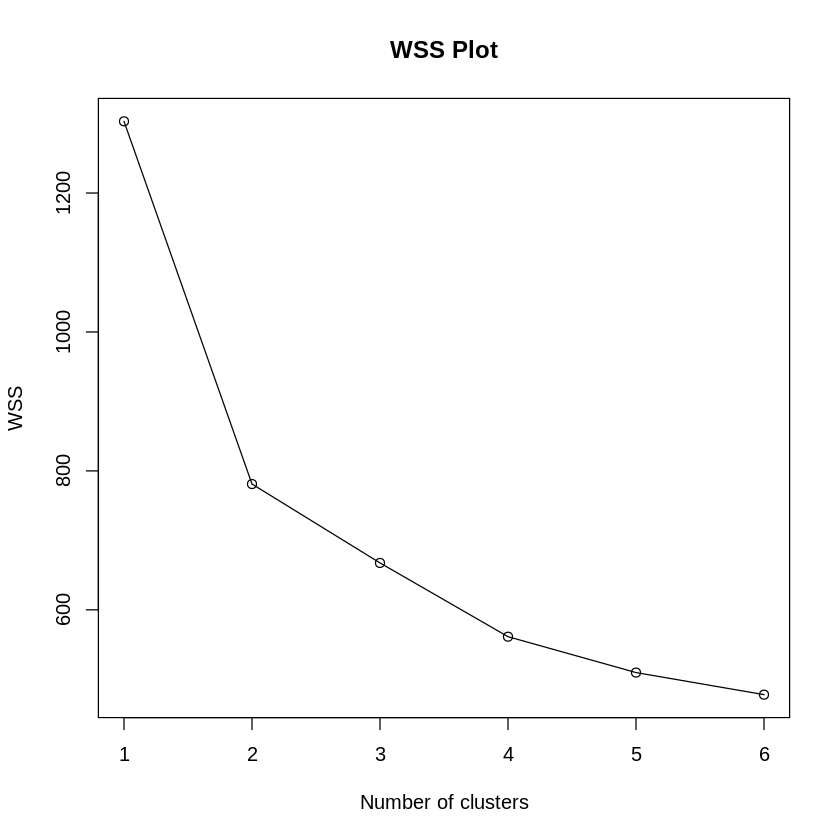

[1] 6


 Only frey, mcclain, cindex, sihouette and dunn can be computed. To compute the other indices, data matrix is needed 
Number_clusters     Value_Index 
         2.0000          0.2242 

 Only frey, mcclain, cindex, sihouette and dunn can be computed. To compute the other indices, data matrix is needed 
Number_clusters     Value_Index 
         2.0000          0.1525 


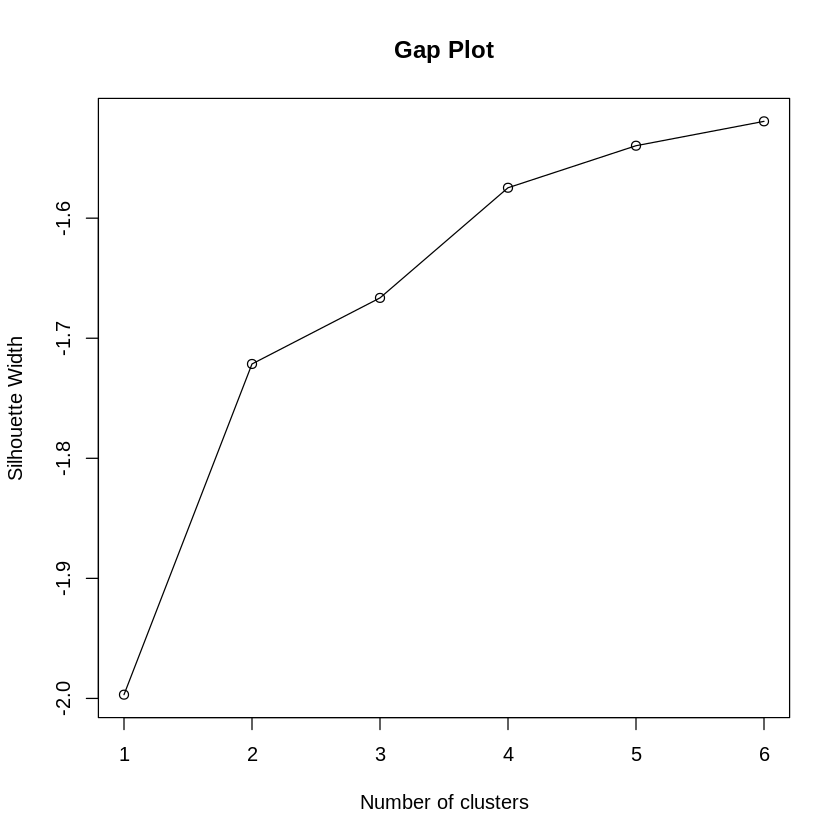

In [115]:
# elbow
pam.elbow(dist = dist, K = 6)

# GAP
pam.GAP(dist = dist, data = insurance.scaled, m = 500, B = 50, K = 6)

# silhouette
print(NbClust::NbClust(diss = dist, max.nc = 6, distance = NULL, method = "centroid", index = "silhouette")$Best.nc)

# dunn index
print(NbClust::NbClust(diss = dist, max.nc = 6, distance = NULL, method = "centroid", index = "dunn")$Best.nc)

According to the GAP statistic method k =: 6




[1] 6

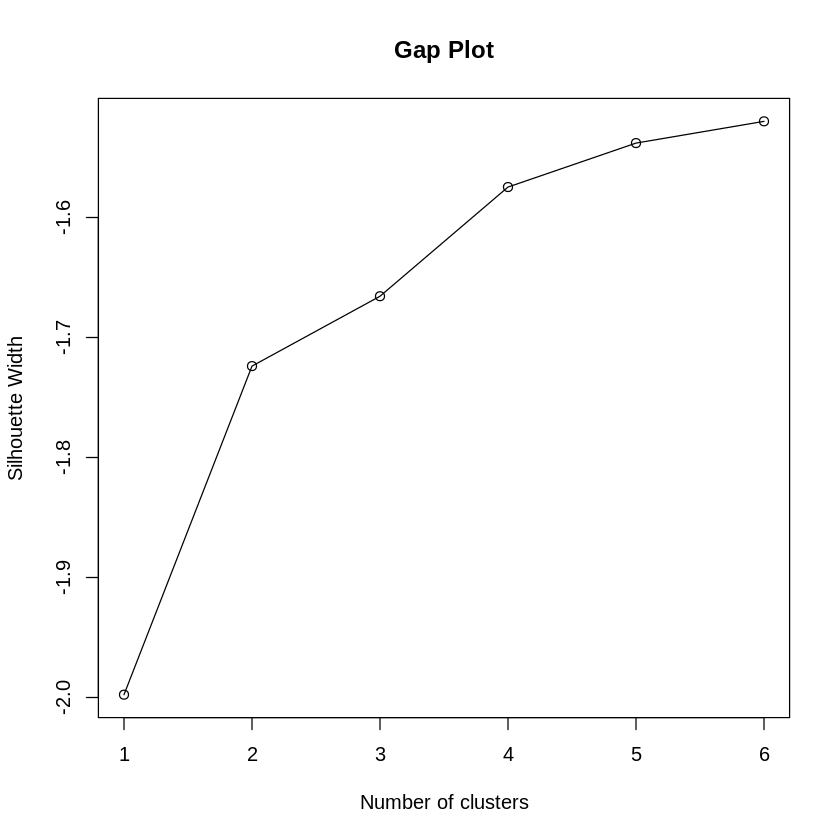

In [113]:
#pam.silh <- 
#summary(pam.silh)


Number_clusters     Value_Index 
         2.0000          0.2242

In [109]:

summary(pam.dunn)


 Only frey, mcclain, cindex, sihouette and dunn can be computed. To compute the other indices, data matrix is needed 


               Length Class  Mode   
All.index         5   -none- numeric
Best.nc           2   -none- numeric
Best.partition 5000   -none- numeric

In [74]:
#cazzo()
#pam.GAP(dist = dist, data = insurance.scaled, m = 11, B = 1, K = 10)
clmethods <- c("hierarchical", "pam")
clvalid <- myClValid::myClValid.cat(insurance.scaled, nClust = 2:6, clMethods = clmethods, validation = c("internal", "stability"), maxitems = nrow(insurance.scaled))


Call:
myClValid::myClValid.cat(obj = insurance.scaled, nClust = 2:6, 
    clMethods = clmethods, validation = c("internal", "stability"), 
    maxitems = nrow(insurance.scaled))

Clustering Methods:
 hierarchical pam 

Cluster sizes:
 2 3 4 5 6 

Validation measures:
 APN AD ADM FOM Connectivity Dunn Silhouette 


In [ ]:
#pam <- pam(dist, diss = T, 4)
#install.packages("clValid")
#library(fpc)
#cluster.stats(dist, pam(dist, diss = T, 3)$cluster)
#library(clValid)
#trace("clValid", edit = T)
install.packages("devtools")
library(devtools)
install_github("biagio-incardona/clValid", force = T)
library(clValid)
clmethods <- c("hierarchical", "pam")
insurance.data <- read.csv("Healt_Insurance.csv")

insurance.data$Driving_License <- as.factor(ifelse(insurance.data$Driving_License == 1, "Yes", "No"))
insurance.data$Previously_Insured <- as.factor(ifelse(insurance.data$Previously_Insured == 1, "Yes", "No"))
insurance.data$Gender <- as.factor(insurance.data$Gender)
insurance.data$Vehicle_Damage <- as.factor(insurance.data$Vehicle_Damage)
insurance.data$Vehicle_Age <- as.factor(insurance.data$Vehicle_Age)


intern <- clValid(insurance.data[1:5000, -12], nClust = 2:6, clMethods = clmethods, validation = "internal", maxitems = nrow(insurance.data[1:5000,-12]))

In [ ]:
insurance.data <- read.csv("Healt_Insurance.csv")
insurance.data$Driving_License <- as.factor(ifelse(insurance.data$Driving_License == 1, "Yes", "No"))
insurance.data$Previously_Insured <- as.factor(ifelse(insurance.data$Previously_Insured == 1, "Yes", "No"))
insurance.data$Gender <- as.factor(insurance.data$Gender)
insurance.data$Vehicle_Damage <- as.factor(insurance.data$Vehicle_Damage)
insurance.data$Vehicle_Age <- as.factor(insurance.data$Vehicle_Age)



In [ ]:
#x <- daisy(insurance.data[1:5000,-12], metric="gower")
summary(intern)

In [ ]:
gower gower.dist(insurance.data[1:5000,-12])

### 7.3 Cluster validation

In [ ]:
#library(ggplot2, warn.conflicts = F, quietly = T)
#library(dplyr, warn.conflicts = F, quietly = T)
#library(Hmisc, warn.conflicts = F, quietly = T)
#library(data.table, warn.conflicts = F, quietly = T)
#library(corrplot, warn.conflicts = F, quietly = T)
#library(factoextra, warn.conflicts = F, quietly = T)
#library(plot3D, warn.conflicts = F, quietly = T)
#library(ggridges, warn.conflicts = F, quietly = T)
#library(tidyr, warn.conflicts = F, quietly = T)
#library(clustertend, warn.conflicts = F, quietly = T)

#709
#max_len <- -1
#seed <- 0
#insurance.data.orig <- read.csv('Healt_Insurance.csv')

#set.seed(12999)

#rows <- sample(1:nrow(insurance.data.orig), 5000)

#insurance.data <- insurance.data.orig[rows,]
#insurance.data$id <- NULL
#rownames(insurance.data) <- 1:nrow(insurance.data)
# ordering the factors
#insurance.data$Vehicle_Age <- ordered(insurance.data$Vehicle_Age, levels = c('< 1 Year','1-2 Year', '> 2 Years'))
#insurance.data$Vehicle_Age <- as.integer(insurance.data$Vehicle_Age)
# check if the variable becomes ordered
#insurance.data$Vintage <- insurance.data$Vintage/365
# transform the dataset into a data.table
#data.table <- as.data.table(insurance.data)

# apply one hot encoding to the transformed dataset
#insurance.ohe.datatable <- mltools :: one_hot(as.data.table(insurance.data))


# transform the encoded data table into a dataset
#insurance.ohe <- as.data.frame(insurance.ohe.datatable)
#insurance.scaled <- as.data.frame(scale(insurance.ohe,center = F, scale = T))
# calculate pca
#pca <- prcomp(insurance.scaled, scale. = F, center = F)

# show some informations
#summary.pca <- summary(pca)

# get the first 3 Principal components
#PC1 <- pca$x[,1]
#PC2 <- pca$x[,2]
#PC3 <- pca$x[,3]

# plot each Principal comonents vs all others
#pairs(as.data.frame(cbind(PC1, PC2, PC3)))
#scatter3D(PC1, PC2, PC3, phi = 0, bty ="g",
#                  xlab = "PC1", ylab = "PC2", zlab = "PC3")

#

# calculate the lower bound
#lower_bound <- median(pca$x[,1]) - 3 * mad(pca$x[,1])

# calculate the upper bound
#upper_bound <- median(pca$x[,1]) + 3 * mad(pca$x[,1])

# get the outliers indexes
#left_outlier_ind <- which(pca$x[,1] < lower_bound)
#right_outlier_ind <- which(pca$x[,1] > upper_bound)

# creating a copy of the data
#hampel.data <- pca$x[,1:3]
#hampel.data <- as.data.frame(hampel.data)

# set the sampler as outlier
#hampel.data$is.outlier <- 1:nrow(hampel.data)

#hampel.data$is.outlier[-left_outlier_ind] = 1 #no outliers
#hampel.data$is.outlier[left_outlier_ind] = 2 # < lower_bound
#hampel.data$is.outlier[right_outlier_ind] = 3 # > upper_bound

# plot the new data
#colVar <- sapply(hampel.data$is.outlier, function(a){ifelse(a == 1,'red', ifelse(a == 2,'green', 'blue'))})
#colVar <- factor(colVar,levels=c('red','green','blue'))

#scatter3D(x=PC1,y=PC2,z=PC3, phi = 0, bty ="g",
#          xlab = "PC1", ylab = "PC2", zlab = "PC3",
#          colvar=as.integer(colVar),
#          colkey=list(at=c(1,2,3),side=4),
#          col=as.character(levels(colVar)))


In [ ]:
#length(left_outlier_ind) + length(right_outlier_ind)